# Importing packages

In [1]:
#!pip install torch_geometric

# Optional dependencies:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import radius_graph
import enum
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_scatter import scatter_add
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

## Helper Functions

In [3]:
def decompose_graph(graph):
    # graph: torch_geometric.data.data.Data
    # TODO: make it more robust
    x, edge_index, edge_attr, global_attr = None, None, None, None
    for key in graph.keys():
        if key=="x":
            x = graph.x
        elif key=="edge_index":
            edge_index = graph.edge_index
        elif key=="edge_attr":
            edge_attr = graph.edge_attr
        elif key=="global_attr":
            global_attr = graph.global_attr
        else:
            pass
    return (x, edge_index, edge_attr, global_attr)

def copy_geometric_data(graph):
    """return a copy of torch_geometric.data.data.Data
    This function should be carefully used based on
    which keys in a given graph.
    """
    node_attr, edge_index, edge_attr, global_attr = decompose_graph(graph)

    ret = Data(x=node_attr, edge_index=edge_index, edge_attr=edge_attr)
    ret.global_attr = global_attr

    return ret

In [4]:
def build_mlp(in_size, hidden_size, out_size, lay_norm=True):

    module = nn.Sequential(nn.Linear(in_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.Linear(hidden_size, out_size))
    if lay_norm: return nn.Sequential(module,  nn.LayerNorm(normalized_shape=out_size))
    return module

# Blocks

In [5]:
class EdgeBlock(nn.Module):
    """ EdgeBlock, a block that updates edge attributes

    Args:
        custom_func: nn.Module, a custom function that updates edge attributes
    """

    def __init__(self, custom_func=None):
        super(EdgeBlock, self).__init__()
        self.net = custom_func

    def forward(self, graph):
        node_attr, edge_index, edge_attr, _ = decompose_graph(graph)
        senders_idx, receivers_idx = edge_index
        edges_to_collect = []

        senders_attr = node_attr[senders_idx]
        receivers_attr = node_attr[receivers_idx]

        edges_to_collect.append(senders_attr)
        edges_to_collect.append(receivers_attr)
        edges_to_collect.append(edge_attr)

        collected_edges = torch.cat(edges_to_collect, dim=1)

        edge_attr_ = self.net(collected_edges)   # Update

        return Data(x=node_attr, edge_attr=edge_attr_, edge_index=edge_index)

class NodeBlock(nn.Module):
    """ NodeBlock, a block that updates node attributes

    Args:
        custom_func: nn.Module, a custom function that updates node attributes
    """

    def __init__(self, custom_func=None):
        super(NodeBlock, self).__init__()
        self.net = custom_func

    def forward(self, graph):
        # Decompose graph
        edge_attr = graph.edge_attr
        nodes_to_collect = []

        _, receivers_idx = graph.edge_index
        num_nodes = graph.num_nodes
        agg_received_edges = scatter_add(edge_attr, receivers_idx, dim=0, dim_size=num_nodes)

        nodes_to_collect.append(graph.x)
        nodes_to_collect.append(agg_received_edges)
        collected_nodes = torch.cat(nodes_to_collect, dim=-1)
        x = self.net(collected_nodes)
        return Data(x=x, edge_attr=edge_attr, edge_index=graph.edge_index)

# Data

In [6]:
def create_gnn_graph(coordinates, displacement_vector, metadata):
    """
    Create a graph data object for a GNN model.

    Args:
    - coordinates (list of tuples): A list of 2D coordinates for each node.
    - target (list of floats): A list of target values for each node.

    Returns:
    - data (Data): A PyG Data object representing the graph.
    """

    # Convert coordinates to tensor
    pos = torch.tensor(coordinates, dtype=torch.float)
    displacement_vector = torch.tensor(displacement_vector, dtype=torch.float).unsqueeze(1)

    # Add the load as a node attribute
    load = torch.rand(pos.size(0), 1) * metadata["P_initial"]

    # Create edges
    num_nodes = len(coordinates)
    edge_index = radius_graph(pos, r=metadata["default_connectivity_radius"], loop=False)

    # Calculate edge attributes (e.g., Euclidean distance)
    distance = torch.norm(pos[edge_index[0]] - pos[edge_index[1]], dim=1).unsqueeze(1)
    # Calculate displacement as vector at each edge
    displacement = (pos[edge_index[1]] - pos[edge_index[0]])

    # Convert E_initial to a PyTorch tensor
    E_initial = torch.tensor(metadata["E_initial"], dtype=torch.float)
    # Correctly generate a tensor with random values uniformly distributed between 0 and 1, then scale by E_initial
    E_edge = torch.rand(edge_index.size(1), 1) * E_initial

    # Now, both tensors have shape [number_of_edges, 1] and can be concatenated
    edge_attr = torch.cat([distance, displacement, E_edge], dim=1)

    # Concat node features and load
    node_features = torch.cat([pos], dim=1)

    # Create a graph data object
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=displacement_vector)

    return data

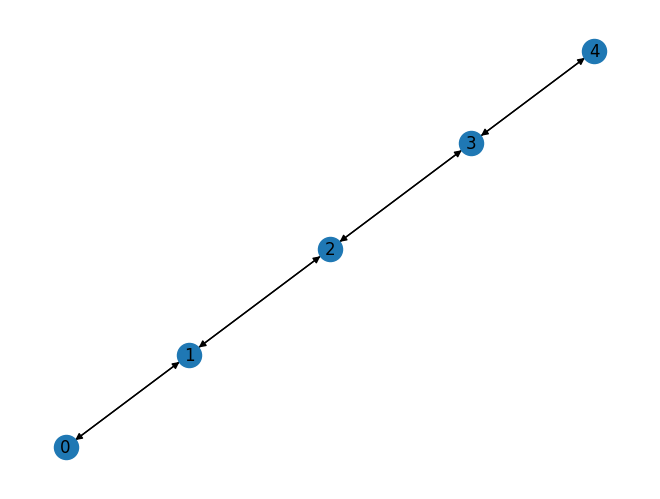

In [37]:
# Example usage
metadata = {"default_connectivity_radius": 1.6, "E_initial": 10, "P_initial": 0.5,
"node_features": ["x", "y", "load"], "edge_features": ["distance", "displacement", "E_edge"],
"node_input_size": 2, "edge_input_size": 4}
coordinates = [(0.5, 0), (1.5, 0), (2.5, 0), (3.5, 0), (4.5, 0)]
displacement = [0, 0.4, 0.5, 0.1, 0.12]
graph_data = create_gnn_graph(coordinates, displacement_vector=displacement, metadata=metadata)

graph = to_networkx(graph_data)
nx.draw(graph, with_labels=True)
plt.show()


# Encoder

In [38]:
class Encoder(nn.Module):
    """ Encoder for the graph neural network. """

    def __init__(self,
                edge_input_size=4,
                node_input_size=2,
                hidden_size=128):
        super(Encoder, self).__init__()

        self.nb_encoder = build_mlp(node_input_size, hidden_size, hidden_size)
        self.eb_encoder = build_mlp(edge_input_size, hidden_size, hidden_size)

    def forward(self, graph):

        node_attr, _, edge_attr, _ = decompose_graph(graph)
        node_ = self.nb_encoder(node_attr)
        edge_ = self.eb_encoder(edge_attr)

        return Data(x=node_, edge_attr=edge_, edge_index=graph.edge_index)

In [39]:
decompose_graph(graph_data)

(tensor([[0.5000, 0.0000],
         [1.5000, 0.0000],
         [2.5000, 0.0000],
         [3.5000, 0.0000],
         [4.5000, 0.0000]]),
 tensor([[1, 0, 2, 1, 3, 2, 4, 3],
         [0, 1, 1, 2, 2, 3, 3, 4]]),
 tensor([[ 1.0000, -1.0000,  0.0000,  7.4239],
         [ 1.0000,  1.0000,  0.0000,  7.4421],
         [ 1.0000, -1.0000,  0.0000,  1.2128],
         [ 1.0000,  1.0000,  0.0000,  4.9194],
         [ 1.0000, -1.0000,  0.0000,  0.0665],
         [ 1.0000,  1.0000,  0.0000,  9.6704],
         [ 1.0000, -1.0000,  0.0000,  9.7626],
         [ 1.0000,  1.0000,  0.0000,  4.6668]]),
 None)

In [40]:
model = Encoder(edge_input_size=4, node_input_size=2, hidden_size=128)
out1 = model(graph_data)

# Decode

In [41]:
class Decoder(nn.Module):
    """ Decoder for the GNN model. """

    def __init__(self, hidden_size=128, output_size=2):
        super(Decoder, self).__init__()
        self.decode_module = build_mlp(hidden_size, hidden_size, output_size, lay_norm=False)

    def forward(self, graph):
        return self.decode_module(graph.x)

In [42]:
model = Decoder(hidden_size=128, output_size=2)
model(out1)

tensor([[-0.1231,  0.0203],
        [-0.1049,  0.0248],
        [-0.0954,  0.0356],
        [-0.0904,  0.0396],
        [-0.0888,  0.0371]], grad_fn=<AddmmBackward0>)

# GN Block

In [43]:
class GnBlock(nn.Module):
    """ Graph Neural Network Block """

    def __init__(self, hidden_size=128):

        super(GnBlock, self).__init__()
        eb_input_dim = 3 * hidden_size
        nb_input_dim = 2 * hidden_size
        nb_custom_func = build_mlp(nb_input_dim, hidden_size, hidden_size)
        eb_custom_func = build_mlp(eb_input_dim, hidden_size, hidden_size)

        self.eb_module = EdgeBlock(custom_func=eb_custom_func)
        self.nb_module = NodeBlock(custom_func=nb_custom_func)

    def forward(self, graph):

        graph_last = copy_geometric_data(graph)
        graph = self.eb_module(graph)
        graph = self.nb_module(graph)
        edge_attr = graph_last.edge_attr + graph.edge_attr
        x = graph_last.x + graph.x
        return Data(x=x, edge_attr=edge_attr, edge_index=graph.edge_index)

In [44]:
model = GnBlock(hidden_size=128)
model(out1)

Data(x=[5, 128], edge_index=[2, 8], edge_attr=[8, 128])

# Model

In [45]:
class EncoderProcesserDecoder(nn.Module):
    """ Encoder-Processer-Decoder model for GNN
    """

    def __init__(self, message_passing_num, node_input_size, edge_input_size, hidden_size=128):
        super(EncoderProcesserDecoder, self).__init__()
        self.encoder = Encoder(edge_input_size=edge_input_size, node_input_size=node_input_size, hidden_size=hidden_size)
        processer_list = []
        for _ in range(message_passing_num):
            processer_list.append(GnBlock(hidden_size=hidden_size))
        self.processer_list = nn.ModuleList(processer_list)

        self.decoder = Decoder(hidden_size=hidden_size, output_size=1)

    def forward(self, graph):

        graph= self.encoder(graph)
        for model in self.processer_list:
            graph = model(graph)
        decoded = self.decoder(graph)

        return decoded

In [47]:
model = EncoderProcesserDecoder(message_passing_num=3, node_input_size=2, edge_input_size=4, hidden_size=40)
pred = model(graph_data)
loss_fn = nn.MSELoss()
loss_fn(pred, graph_data.y)

tensor(0.1391, grad_fn=<MseLossBackward0>)

# Simulator

In [26]:
class Simulator(nn.Module):
    """ Simulator model for the GNN

    Args:
        message_passing_num: int, number of message passing iterations
        node_input_size: int, size of the node input
        edge_input_size: int, size of the edge input
        device: torch.device, device to run the model
        model_dir: str, path to the model checkpoint
    """

    def __init__(self, message_passing_num, node_input_size, edge_input_size, device, model_dir='checkpoint/simulator.pth') -> None:
        super(Simulator, self).__init__()

        self.node_input_size =  node_input_size
        self.edge_input_size = edge_input_size
        self.model_dir = model_dir
        self.model = EncoderProcesserDecoder(message_passing_num=message_passing_num, node_input_size=node_input_size, edge_input_size=edge_input_size).to(device)

        print('Simulator model initialized')


    def forward(self, graph:Data):

        predicted = self.model(graph)
        target = graph.y

        return predicted, target

    def save(self):
        if self.model_dir is not None:
            os.makedirs(os.path.dirname(self.model_dir), exist_ok=True)

        torch.save(self.model.state_dict(), self.model_dir)

    def load(self):
        if self.model_dir is not None:
            self.model.load_state_dict(torch.load(self.model_dir))


In [48]:
model = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=torch.device('cpu'))
pred, target = model.forward(graph_data)


Simulator model initialized


# Training

In [49]:
import torch
from torch.optim.lr_scheduler import StepLR  # Import StepLR

dataset_dir = 'dataset'
batch_size = 20

print_batch = 10
save_batch = 200


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
simulator = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=device)
optimizer = torch.optim.Adam(simulator.model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

print('Optimizer initialized')

Simulator model initialized
Optimizer initialized


In [50]:
import torch_geometric.transforms as T
transformer = T.Compose([T.FaceToEdge(), T.Cartesian(norm=False), T.Distance(norm=False)])

In [53]:
loss_fn = torch.nn.MSELoss()

pred, target = simulator(graph_data)
loss_fn(pred, target)

tensor(0.0953, grad_fn=<MseLossBackward0>)

In [59]:
import tqdm
from torch.optim.lr_scheduler import StepLR

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

def train(model: Simulator, dataloader, optimizer, scheduler, loss_fn, epochs=1, print_epoch=5, save_epoch=100):
    model.to(device)

    # Save losses
    losses = []
    for epoch in tqdm.tqdm(range(epochs), desc="Epochs"):
        for batch_index, graph in enumerate(tqdm.tqdm(dataloader, desc="Batches", leave=False)):
            graph = graph.to(device)
            optimizer.zero_grad()
            pred, target = model(graph)
            loss = loss_fn(pred, target)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()
                # Update
                #scheduler

            if batch_index % print_batch == 0:
                print(f'Batch {batch_index}, Epoch {epoch} [Loss: {loss.item():.2e}]')

            if batch_index % save_batch == 0:
                model.save()
                #print('Model saved')

                # Save losses
        losses.append(loss.item())

    return losses






# Dataloader

In [55]:
import pandas as pd

train_dataset_dir = 'https://github.com/jamesterryxu/dsa-2024/raw/main/data.json'
test_dataset_dir = "https://github.com/jamesterryxu/dsa-2024/raw/main/data/JSON_Data_Updated/n=100_p=2_varying_l_vectors.json"


In [56]:
import pandas as pd
import numpy as np
from torch_geometric.data import Dataset
from torch_geometric.data import DataLoader

class GraphDataset(Dataset):
    def __init__(self, dataset_dir, metadata):
        self.df = pd.read_json(dataset_dir)
        #self.df = self.df.applymap(lambda x: np.array(x))
        self.metadata = metadata

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        displacement_y = self.df["Displacement"].iloc[idx]
        coordinates = self.df["Coord"].iloc[idx]
        EI = self.df["EI"].iloc[idx]
        self.metadata["default_connectivity_radius"] = np.hypot(*np.diff(coordinates, axis=0).T).mean() * 1.05
        #print(self.metadata["default_connectivity_radius"])
        graph_data = create_gnn_graph(coordinates, displacement_y, self.metadata)
        return graph_data


In [57]:
train_dataloader = DataLoader(GraphDataset(train_dataset_dir, metadata), batch_size=1000, shuffle=True)
test_dataloader = DataLoader(GraphDataset(test_dataset_dir, metadata), batch_size=1, shuffle=True)

C:\Users\kurt-\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\kurt-\AppData\Roaming\Python\Python312\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Train test

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
simulator = Simulator(message_passing_num=3, node_input_size=2, edge_input_size=4, device=device)
optimizer = torch.optim.Adam(simulator.model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

cpu
Simulator model initialized


In [61]:
losses = train(simulator, train_dataloader, optimizer, scheduler, loss_fn, epochs=1)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batch 0, Epoch 0 [Loss: 5.88e+02]


Epochs:   0%|          | 0/1 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

In [49]:
for batch_index, graph in enumerate(test_dataloader):
  print(graph)

DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])
DataBatch(x=[100, 2], edge_index=[2, 198], edge_attr=[198, 4], y=[100, 1], batch=[100], ptr=[2])


In [50]:
def test(model:Simulator, dataloader):
    loss = 0
    with torch.no_grad():
      model.eval()
      for batch_index, graph in enumerate(dataloader):
          graph = graph.to(device)
          target = graph.y
          pred, target = model(graph)
          loss += loss_data(pred, target).item()

    return loss / len(dataloader)

test(simulator, test_dataloader)

41.994729151390494

# Result

In [51]:
# Create a function to plot the graph.x vs graph.y
def plot_results(model, dataloader):
    for batch_index, graph in enumerate(dataloader):
      print(batch_index)
      with torch.no_grad():
        model.eval()
        graph = graph.to(device)
        pred, target = model(graph)
        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()
        x_coord = graph.x[:,0].detach().cpu().numpy()
        print(x_coord)
        plt.figure(figsize=(10, 6))
        plt.plot(x_coord, target, label='target', marker='x')
        plt.plot(x_coord, pred[:,0], label='predicted', marker='o')
        plt.legend()
        plt.show()


0
[0.         0.04040404 0.08080808 0.12121212 0.16161616 0.2020202
 0.24242425 0.28282827 0.32323232 0.36363637 0.4040404  0.44444445
 0.4848485  0.5252525  0.56565654 0.6060606  0.64646465 0.68686867
 0.72727275 0.7676768  0.8080808  0.8484849  0.8888889  0.9292929
 0.969697   1.010101   1.050505   1.0909091  1.1313131  1.1717172
 1.2121212  1.2525252  1.2929293  1.3333334  1.3737373  1.4141414
 1.4545455  1.4949495  1.5353535  1.5757576  1.6161616  1.6565657
 1.6969697  1.7373737  1.7777778  1.8181819  1.8585858  1.8989899
 1.939394   1.979798   2.020202   2.060606   2.10101    2.1414142
 2.1818182  2.2222223  2.2626262  2.3030303  2.3434343  2.3838384
 2.4242425  2.4646466  2.5050504  2.5454545  2.5858586  2.6262627
 2.6666667  2.7070706  2.7474747  2.7878788  2.8282828  2.868687
 2.909091   2.9494948  2.989899   3.030303   3.070707   3.1111112
 3.1515152  3.191919   3.2323232  3.2727273  3.3131313  3.3535354
 3.3939395  3.4343433  3.4747474  3.5151515  3.5555556  3.5959597
 3.6363

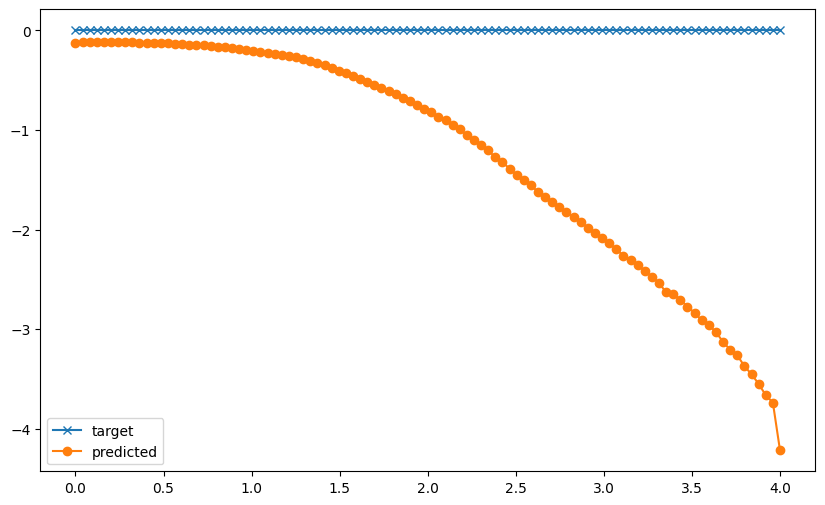

1
[ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.5050505
  0.6060606   0.7070707   0.8080808   0.90909094  1.010101    1.1111112
  1.2121212   1.3131313   1.4141414   1.5151515   1.6161616   1.7171717
  1.8181819   1.919192    2.020202    2.121212    2.2222223   2.3232324
  2.4242425   2.5252526   2.6262627   2.7272727   2.8282828   2.929293
  3.030303    3.131313    3.2323232   3.3333333   3.4343433   3.5353534
  3.6363637   3.7373738   3.838384    3.939394    4.040404    4.141414
  4.242424    4.3434343   4.4444447   4.5454545   4.646465    4.7474747
  4.848485    4.949495    5.050505    5.151515    5.2525253   5.353535
  5.4545455   5.5555553   5.6565657   5.757576    5.858586    5.959596
  6.060606    6.1616163   6.262626    6.3636365   6.4646463   6.5656567
  6.6666665   6.767677    6.8686867   6.969697    7.070707    7.171717
  7.2727275   7.3737373   7.4747477   7.5757575   7.676768    7.7777777
  7.878788    7.979798    8.080808    8.181818    8.282828    8.383

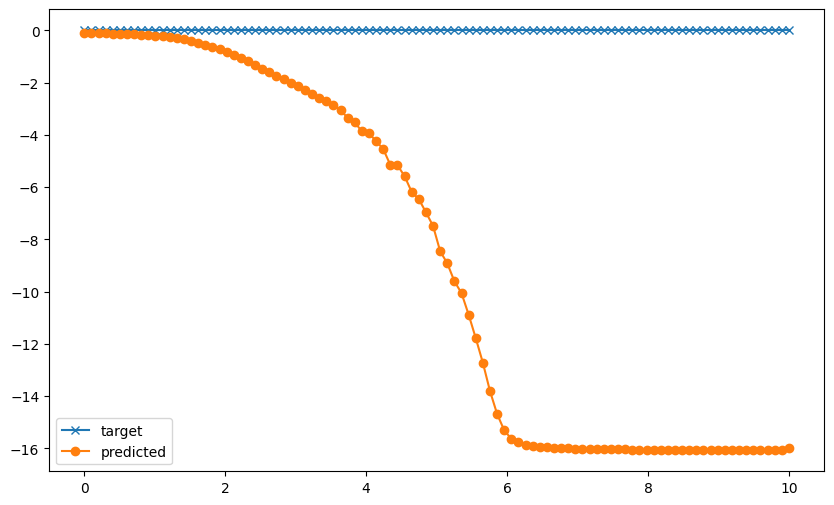

2
[0.         0.09090909 0.18181819 0.27272728 0.36363637 0.45454547
 0.54545456 0.6363636  0.72727275 0.8181818  0.90909094 1.
 1.0909091  1.1818181  1.2727273  1.3636364  1.4545455  1.5454545
 1.6363636  1.7272727  1.8181819  1.9090909  2.         2.090909
 2.1818182  2.2727273  2.3636363  2.4545455  2.5454545  2.6363637
 2.7272727  2.8181818  2.909091   3.         3.090909   3.1818182
 3.2727273  3.3636363  3.4545455  3.5454545  3.6363637  3.7272727
 3.8181818  3.909091   4.         4.090909   4.181818   4.2727275
 4.3636365  4.4545455  4.5454545  4.6363635  4.7272725  4.818182
 4.909091   5.         5.090909   5.181818   5.2727275  5.3636365
 5.4545455  5.5454545  5.6363635  5.7272725  5.818182   5.909091
 6.         6.090909   6.181818   6.2727275  6.3636365  6.4545455
 6.5454545  6.6363635  6.7272725  6.818182   6.909091   7.
 7.090909   7.181818   7.2727275  7.3636365  7.4545455  7.5454545
 7.6363635  7.7272725  7.818182   7.909091   8.         8.090909
 8.181818   8.272727   8.

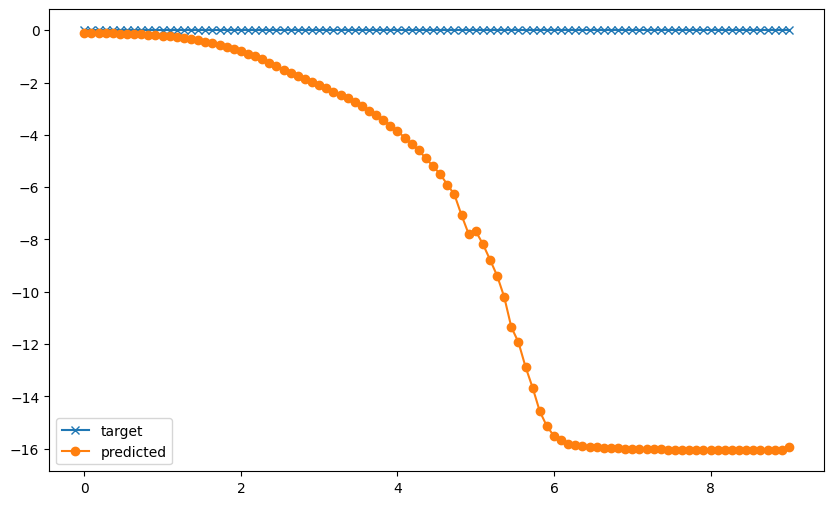

3
[0.         0.08080808 0.16161616 0.24242425 0.32323232 0.4040404
 0.4848485  0.56565654 0.64646465 0.72727275 0.8080808  0.8888889
 0.969697   1.050505   1.1313131  1.2121212  1.2929293  1.3737373
 1.4545455  1.5353535  1.6161616  1.6969697  1.7777778  1.8585858
 1.939394   2.020202   2.10101    2.1818182  2.2626262  2.3434343
 2.4242425  2.5050504  2.5858586  2.6666667  2.7474747  2.8282828
 2.909091   2.989899   3.070707   3.1515152  3.2323232  3.3131313
 3.3939395  3.4747474  3.5555556  3.6363637  3.7171717  3.7979798
 3.878788   3.959596   4.040404   4.121212   4.20202    4.2828283
 4.3636365  4.4444447  4.5252523  4.6060605  4.6868687  4.767677
 4.848485   4.929293   5.010101   5.090909   5.171717   5.2525253
 5.3333335  5.414141   5.4949493  5.5757575  5.6565657  5.737374
 5.818182   5.8989897  5.979798   6.060606   6.141414   6.2222223
 6.3030305  6.383838   6.4646463  6.5454545  6.6262627  6.707071
 6.787879   6.8686867  6.949495   7.030303   7.111111   7.1919193
 7.2727275 

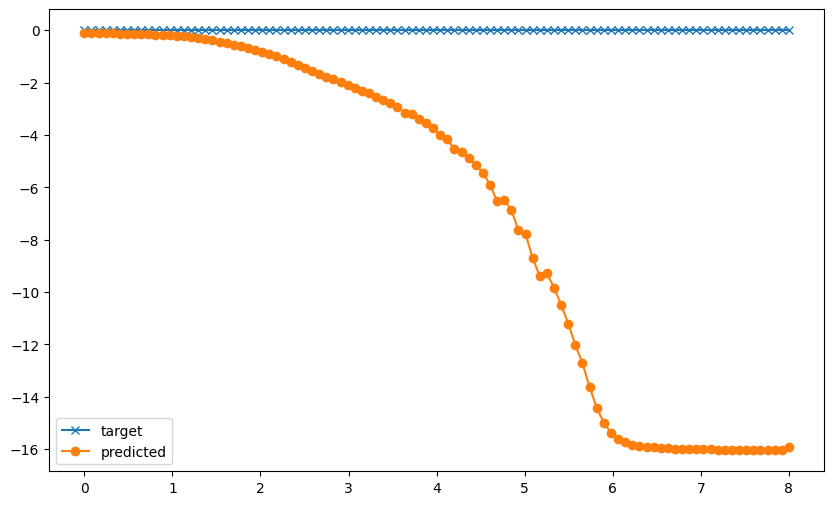

4
[0.         0.06060606 0.12121212 0.18181819 0.24242425 0.3030303
 0.36363637 0.42424244 0.4848485  0.54545456 0.6060606  0.6666667
 0.72727275 0.7878788  0.8484849  0.90909094 0.969697   1.030303
 1.0909091  1.1515151  1.2121212  1.2727273  1.3333334  1.3939394
 1.4545455  1.5151515  1.5757576  1.6363636  1.6969697  1.7575758
 1.8181819  1.8787879  1.939394   2.         2.060606   2.121212
 2.1818182  2.2424242  2.3030303  2.3636363  2.4242425  2.4848485
 2.5454545  2.6060605  2.6666667  2.7272727  2.7878788  2.8484848
 2.909091   2.969697   3.030303   3.090909   3.1515152  3.2121212
 3.2727273  3.3333333  3.3939395  3.4545455  3.5151515  3.5757575
 3.6363637  3.6969697  3.7575758  3.8181818  3.878788   3.939394
 4.         4.060606   4.121212   4.181818   4.242424   4.3030305
 4.3636365  4.4242425  4.4848485  4.5454545  4.6060605  4.6666665
 4.7272725  4.787879   4.848485   4.909091   4.969697   5.030303
 5.090909   5.151515   5.212121   5.2727275  5.3333335  5.3939395
 5.4545455  

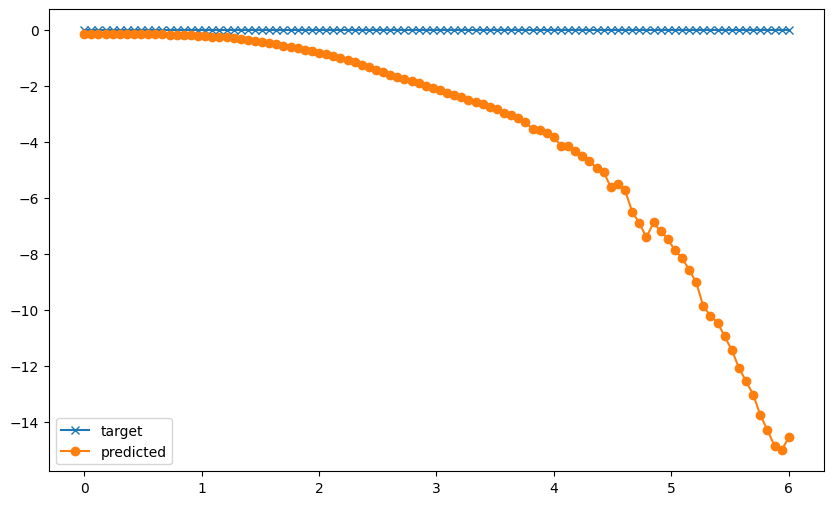

5
[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151516 0.16161616 0.17171717
 0.18181819 0.1919192  0.2020202  0.21212122 0.22222222 0.23232323
 0.24242425 0.25252524 0.26262626 0.27272728 0.28282827 0.2929293
 0.3030303  0.3131313  0.32323232 0.33333334 0.34343433 0.35353535
 0.36363637 0.37373737 0.3838384  0.3939394  0.4040404  0.41414142
 0.42424244 0.43434343 0.44444445 0.45454547 0.46464646 0.47474748
 0.4848485  0.4949495  0.5050505  0.5151515  0.5252525  0.53535354
 0.54545456 0.5555556  0.56565654 0.57575756 0.5858586  0.5959596
 0.6060606  0.61616164 0.6262626  0.6363636  0.64646465 0.65656567
 0.6666667  0.67676765 0.68686867 0.6969697  0.7070707  0.7171717
 0.72727275 0.7373737  0.74747473 0.75757575 0.7676768  0.7777778
 0.7878788  0.7979798  0.8080808  0.8181818  0.82828283 0.83838385
 0.8484849  0.85858583 0.86868685 0.8787879  0.8888889  0.898989

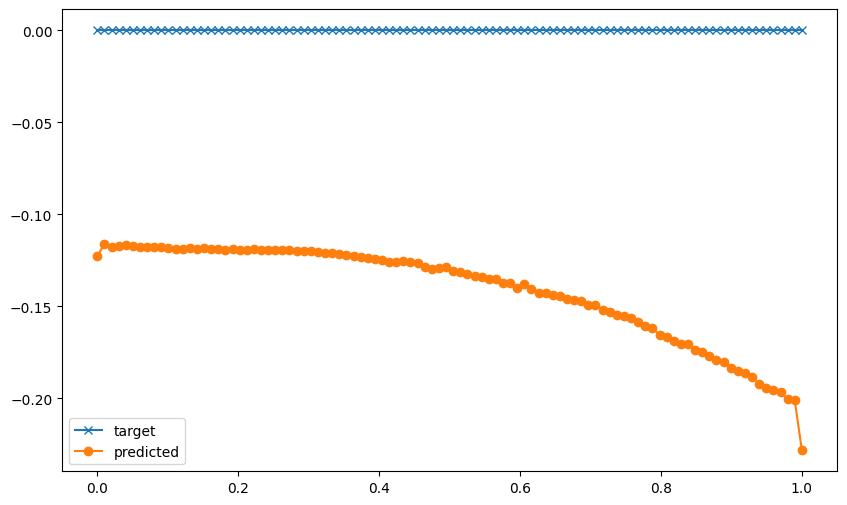

6
[0.         0.07070707 0.14141414 0.21212122 0.28282827 0.35353535
 0.42424244 0.4949495  0.56565654 0.6363636  0.7070707  0.7777778
 0.8484849  0.9191919  0.989899   1.060606   1.1313131  1.2020202
 1.2727273  1.3434343  1.4141414  1.4848485  1.5555556  1.6262627
 1.6969697  1.7676767  1.8383838  1.9090909  1.979798   2.0505052
 2.121212   2.191919   2.2626262  2.3333333  2.4040403  2.4747474
 2.5454545  2.6161616  2.6868687  2.7575758  2.8282828  2.89899
 2.969697   3.040404   3.1111112  3.1818182  3.2525253  3.3232324
 3.3939395  3.4646466  3.5353534  3.6060605  3.6767676  3.7474747
 3.8181818  3.8888888  3.959596   4.030303   4.1010103  4.171717
 4.242424   4.3131313  4.383838   4.4545455  4.5252523  4.5959597
 4.6666665  4.737374   4.8080807  4.878788   4.949495   5.020202
 5.090909   5.1616163  5.232323   5.3030305  5.3737373  5.4444447
 5.5151515  5.585859   5.6565657  5.7272725  5.79798    5.8686867
 5.939394   6.010101   6.080808   6.151515   6.2222223  6.292929
 6.3636365  

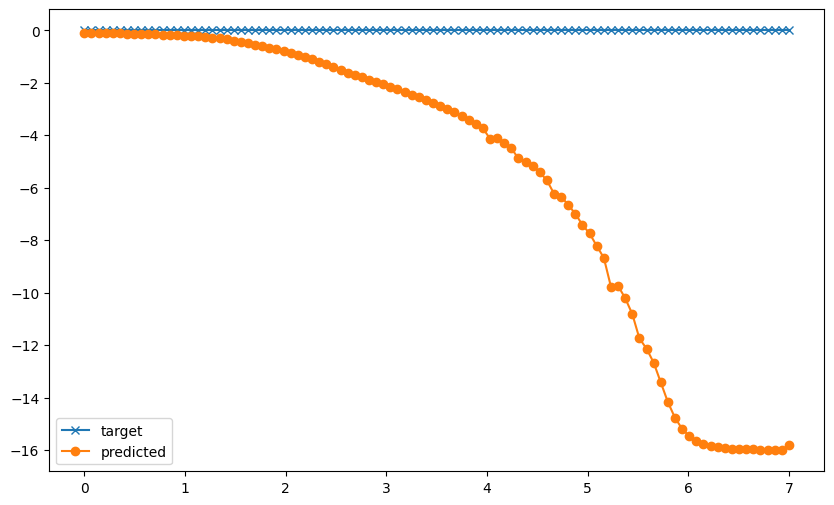

7
[0.         0.02020202 0.04040404 0.06060606 0.08080808 0.1010101
 0.12121212 0.14141414 0.16161616 0.18181819 0.2020202  0.22222222
 0.24242425 0.26262626 0.28282827 0.3030303  0.32323232 0.34343433
 0.36363637 0.3838384  0.4040404  0.42424244 0.44444445 0.46464646
 0.4848485  0.5050505  0.5252525  0.54545456 0.56565654 0.5858586
 0.6060606  0.6262626  0.64646465 0.6666667  0.68686867 0.7070707
 0.72727275 0.74747473 0.7676768  0.7878788  0.8080808  0.82828283
 0.8484849  0.86868685 0.8888889  0.90909094 0.9292929  0.94949496
 0.969697   0.989899   1.010101   1.030303   1.050505   1.0707071
 1.0909091  1.1111112  1.1313131  1.1515151  1.1717172  1.1919192
 1.2121212  1.2323233  1.2525252  1.2727273  1.2929293  1.3131313
 1.3333334  1.3535353  1.3737373  1.3939394  1.4141414  1.4343435
 1.4545455  1.4747474  1.4949495  1.5151515  1.5353535  1.5555556
 1.5757576  1.5959595  1.6161616  1.6363636  1.6565657  1.6767677
 1.6969697  1.7171717  1.7373737  1.7575758  1.7777778  1.7979798
 1.

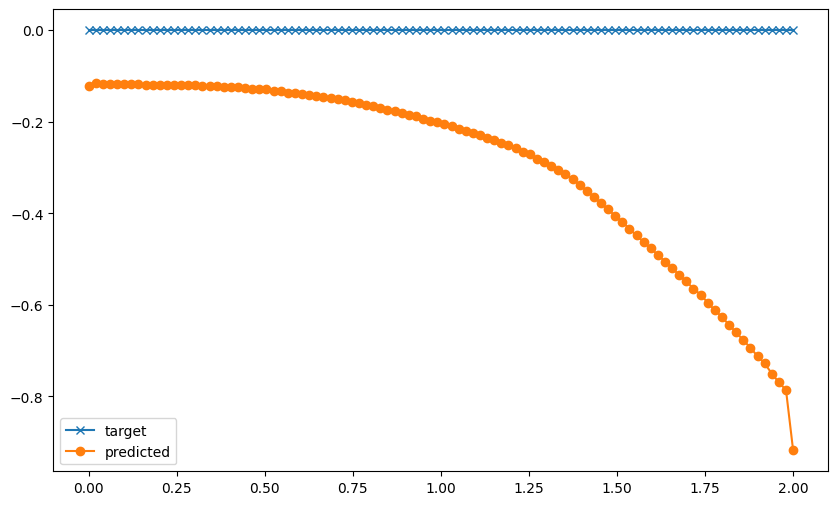

8
[0.         0.05050505 0.1010101  0.15151516 0.2020202  0.25252524
 0.3030303  0.35353535 0.4040404  0.45454547 0.5050505  0.5555556
 0.6060606  0.65656567 0.7070707  0.75757575 0.8080808  0.85858583
 0.90909094 0.959596   1.010101   1.060606   1.1111112  1.1616162
 1.2121212  1.2626263  1.3131313  1.3636364  1.4141414  1.4646465
 1.5151515  1.5656565  1.6161616  1.6666666  1.7171717  1.7676767
 1.8181819  1.8686869  1.919192   1.969697   2.020202   2.070707
 2.121212   2.1717172  2.2222223  2.2727273  2.3232324  2.3737373
 2.4242425  2.4747474  2.5252526  2.5757575  2.6262627  2.6767676
 2.7272727  2.7777777  2.8282828  2.878788   2.929293   2.979798
 3.030303   3.0808082  3.131313   3.1818182  3.2323232  3.2828283
 3.3333333  3.3838384  3.4343433  3.4848485  3.5353534  3.5858586
 3.6363637  3.6868687  3.7373738  3.7878788  3.838384   3.8888888
 3.939394   3.989899   4.040404   4.090909   4.141414   4.1919193
 4.242424   4.292929   4.3434343  4.3939395  4.4444447  4.4949493
 4.54545

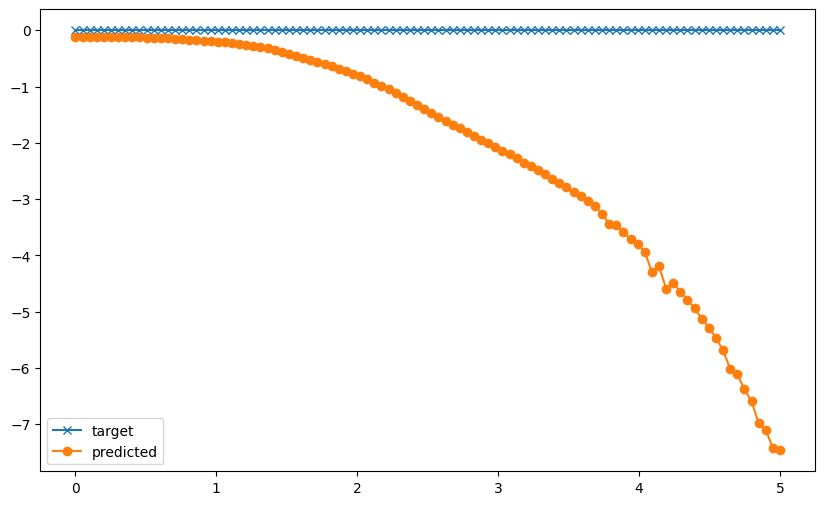

9
[0.         0.03030303 0.06060606 0.09090909 0.12121212 0.15151516
 0.18181819 0.21212122 0.24242425 0.27272728 0.3030303  0.33333334
 0.36363637 0.3939394  0.42424244 0.45454547 0.4848485  0.5151515
 0.54545456 0.57575756 0.6060606  0.6363636  0.6666667  0.6969697
 0.72727275 0.75757575 0.7878788  0.8181818  0.8484849  0.8787879
 0.90909094 0.93939394 0.969697   1.         1.030303   1.060606
 1.0909091  1.1212121  1.1515151  1.1818181  1.2121212  1.2424242
 1.2727273  1.3030303  1.3333334  1.3636364  1.3939394  1.4242424
 1.4545455  1.4848485  1.5151515  1.5454545  1.5757576  1.6060606
 1.6363636  1.6666666  1.6969697  1.7272727  1.7575758  1.7878788
 1.8181819  1.8484849  1.8787879  1.9090909  1.939394   1.969697
 2.         2.030303   2.060606   2.090909   2.121212   2.1515152
 2.1818182  2.2121212  2.2424242  2.2727273  2.3030303  2.3333333
 2.3636363  2.3939395  2.4242425  2.4545455  2.4848485  2.5151515
 2.5454545  2.5757575  2.6060605  2.6363637  2.6666667  2.6969697
 2.72727

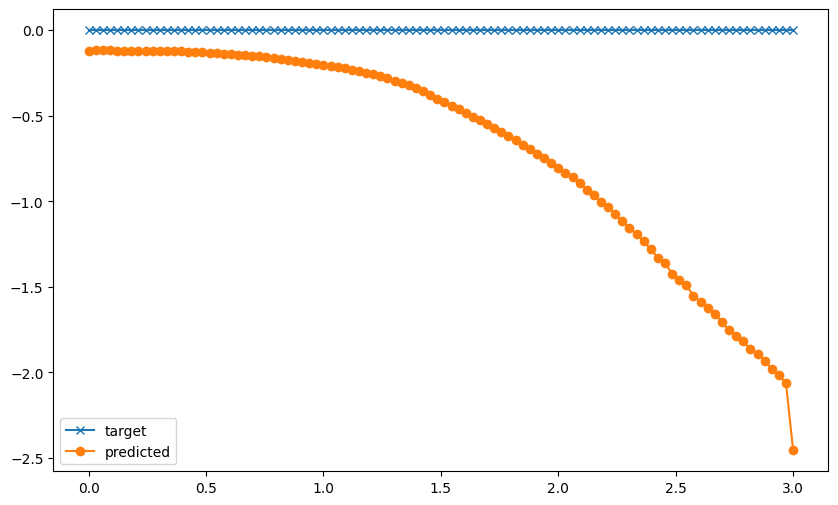

In [53]:
plot_results(simulator, test_dataloader)

# Do PINN

In [54]:
def loss_PDE(x, pred, q=torch.tensor(0.0)):
    x.requires_grad = True
    EI = pred[:,1]
    u = pred[:,0].unsqueeze(1)
    u_x = torch.autograd.grad(u, x, create_graph=True, grad_outputs=torch.ones_like(u), allow_unused=True)[0][:,0]
    u_xx = torch.autograd.grad(u_x, x, create_graph=True, grad_outputs=torch.ones_like(u_x), allow_unused=True)[0][:,0]
    u_xxx = torch.autograd.grad(u_xx, x, create_graph=True, grad_outputs=torch.ones_like(u_xx), allow_unused=True)[0][:,0]
    u_x4 = torch.autograd.grad(u_xxx, x, create_graph=True, grad_outputs=torch.ones_like(u_xxx), allow_unused=True)[0][:,0]

    # PDE
    fn = EI*u_x4 - q
    return torch.mean(fn**2)

def loss_data(pred, target):
    return F.mse_loss(pred[:,0].unsqueeze(1), target)

def loss_BC(w):
    fn = w[0] - 0.0
    return torch.mean(fn**2)

def loss_total(x, pred, target, q=torch.tensor(0.0)):
    return loss_PDE(x, pred, q) + loss_data(pred, target) + loss_BC(pred[:,0])

In [55]:
for batch_index, graph in enumerate(tqdm.tqdm(train_dataloader, desc="Batches")):
  A = graph
  break

Batches:   0%|          | 0/2500 [00:00<?, ?it/s]


In [65]:
pred, target = simulator(A.to(device))
loss_total(A.x, pred, target, q=torch.tensor(0.0))

tensor(1105.8988, device='cuda:0', grad_fn=<AddBackward0>)

In [67]:
import torch.nn.functional as F

def train_PDE(model, dataloader, optimizer, scheduler=None, epochs=100, print_batch=5, save_batch=10):
  model.to(device)
  loss_list = []
  for batch_index, graph in enumerate(tqdm.tqdm(dataloader, desc="Batches")):
      for epoch in tqdm.tqdm(range(epochs), desc="Epochs", leave=False):
          graph = graph.to(device)
          model.train()  # Ensure the model is in training mode
          pred, target = model(graph)
          loss = F.mse_loss(pred, target)

          loss_list.append(loss.item())

          # Ensure loss is a scalar
          if loss.dim() > 0:
              loss = loss.mean()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if scheduler:
              scheduler.step()  # Update the learning rate if scheduler is provided

          if batch_index % print_batch == 0:
              print(f'Batch {batch_index}, Epoch {epoch} [Loss: {loss.item():.2e}]')

          if batch_index % save_batch == 0:
              model.save()
              #print('Model saved')

  return loss_list


# Example usage with a learning rate scheduler
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

losses_PDE = train_PDE(model, train_dataloader, optimizer, scheduler)


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-67-4c296637675a>:11: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(pred, target)

Epochs:   4%|▍         | 4/100 [00:00<00:02, 34.41it/s]

Batch 0, Epoch 0 [Loss: 1.89e+01]
Batch 0, Epoch 1 [Loss: 1.88e+01]
Batch 0, Epoch 2 [Loss: 1.87e+01]
Batch 0, Epoch 3 [Loss: 1.86e+01]
Batch 0, Epoch 4 [Loss: 1.84e+01]
Batch 0, Epoch 5 [Loss: 1.83e+01]
Batch 0, Epoch 6 [Loss: 1.82e+01]
Batch 0, Epoch 7 [Loss: 1.81e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:02, 36.40it/s]

Batch 0, Epoch 8 [Loss: 1.79e+01]
Batch 0, Epoch 9 [Loss: 1.78e+01]
Batch 0, Epoch 10 [Loss: 1.77e+01]
Batch 0, Epoch 11 [Loss: 1.77e+01]
Batch 0, Epoch 12 [Loss: 1.76e+01]
Batch 0, Epoch 13 [Loss: 1.76e+01]
Batch 0, Epoch 14 [Loss: 1.76e+01]
Batch 0, Epoch 15 [Loss: 1.76e+01]



Epochs:  20%|██        | 20/100 [00:00<00:02, 37.06it/s]

Batch 0, Epoch 16 [Loss: 1.76e+01]
Batch 0, Epoch 17 [Loss: 1.76e+01]
Batch 0, Epoch 18 [Loss: 1.76e+01]
Batch 0, Epoch 19 [Loss: 1.75e+01]
Batch 0, Epoch 20 [Loss: 1.75e+01]
Batch 0, Epoch 21 [Loss: 1.75e+01]
Batch 0, Epoch 22 [Loss: 1.75e+01]



Epochs:  28%|██▊       | 28/100 [00:00<00:02, 32.41it/s]

Batch 0, Epoch 23 [Loss: 1.75e+01]
Batch 0, Epoch 24 [Loss: 1.75e+01]
Batch 0, Epoch 25 [Loss: 1.75e+01]
Batch 0, Epoch 26 [Loss: 1.75e+01]
Batch 0, Epoch 27 [Loss: 1.75e+01]
Batch 0, Epoch 28 [Loss: 1.75e+01]



Epochs:  36%|███▌      | 36/100 [00:01<00:01, 33.40it/s]

Batch 0, Epoch 29 [Loss: 1.75e+01]
Batch 0, Epoch 30 [Loss: 1.75e+01]
Batch 0, Epoch 31 [Loss: 1.75e+01]
Batch 0, Epoch 32 [Loss: 1.75e+01]
Batch 0, Epoch 33 [Loss: 1.75e+01]
Batch 0, Epoch 34 [Loss: 1.75e+01]
Batch 0, Epoch 35 [Loss: 1.75e+01]
Batch 0, Epoch 36 [Loss: 1.75e+01]



Epochs:  44%|████▍     | 44/100 [00:01<00:01, 34.82it/s]

Batch 0, Epoch 37 [Loss: 1.75e+01]
Batch 0, Epoch 38 [Loss: 1.75e+01]
Batch 0, Epoch 39 [Loss: 1.75e+01]
Batch 0, Epoch 40 [Loss: 1.75e+01]
Batch 0, Epoch 41 [Loss: 1.75e+01]
Batch 0, Epoch 42 [Loss: 1.75e+01]
Batch 0, Epoch 43 [Loss: 1.75e+01]
Batch 0, Epoch 44 [Loss: 1.75e+01]



Epochs:  52%|█████▏    | 52/100 [00:01<00:01, 35.72it/s]

Batch 0, Epoch 45 [Loss: 1.75e+01]
Batch 0, Epoch 46 [Loss: 1.75e+01]
Batch 0, Epoch 47 [Loss: 1.75e+01]
Batch 0, Epoch 48 [Loss: 1.75e+01]
Batch 0, Epoch 49 [Loss: 1.75e+01]
Batch 0, Epoch 50 [Loss: 1.75e+01]
Batch 0, Epoch 51 [Loss: 1.75e+01]
Batch 0, Epoch 52 [Loss: 1.75e+01]



Epochs:  60%|██████    | 60/100 [00:01<00:01, 36.35it/s]

Batch 0, Epoch 53 [Loss: 1.75e+01]
Batch 0, Epoch 54 [Loss: 1.75e+01]
Batch 0, Epoch 55 [Loss: 1.75e+01]
Batch 0, Epoch 56 [Loss: 1.75e+01]
Batch 0, Epoch 57 [Loss: 1.75e+01]
Batch 0, Epoch 58 [Loss: 1.75e+01]
Batch 0, Epoch 59 [Loss: 1.75e+01]
Batch 0, Epoch 60 [Loss: 1.75e+01]



Epochs:  68%|██████▊   | 68/100 [00:01<00:00, 36.11it/s]

Batch 0, Epoch 61 [Loss: 1.75e+01]
Batch 0, Epoch 62 [Loss: 1.75e+01]
Batch 0, Epoch 63 [Loss: 1.75e+01]
Batch 0, Epoch 64 [Loss: 1.75e+01]
Batch 0, Epoch 65 [Loss: 1.75e+01]
Batch 0, Epoch 66 [Loss: 1.75e+01]
Batch 0, Epoch 67 [Loss: 1.75e+01]
Batch 0, Epoch 68 [Loss: 1.75e+01]



Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 37.04it/s]

Batch 0, Epoch 69 [Loss: 1.75e+01]
Batch 0, Epoch 70 [Loss: 1.75e+01]
Batch 0, Epoch 71 [Loss: 1.75e+01]
Batch 0, Epoch 72 [Loss: 1.75e+01]
Batch 0, Epoch 73 [Loss: 1.75e+01]
Batch 0, Epoch 74 [Loss: 1.75e+01]
Batch 0, Epoch 75 [Loss: 1.75e+01]
Batch 0, Epoch 76 [Loss: 1.75e+01]



Epochs:  84%|████████▍ | 84/100 [00:02<00:00, 36.71it/s]

Batch 0, Epoch 77 [Loss: 1.75e+01]
Batch 0, Epoch 78 [Loss: 1.75e+01]
Batch 0, Epoch 79 [Loss: 1.75e+01]
Batch 0, Epoch 80 [Loss: 1.75e+01]
Batch 0, Epoch 81 [Loss: 1.75e+01]
Batch 0, Epoch 82 [Loss: 1.75e+01]
Batch 0, Epoch 83 [Loss: 1.75e+01]
Batch 0, Epoch 84 [Loss: 1.75e+01]



Epochs:  92%|█████████▏| 92/100 [00:02<00:00, 36.74it/s]

Batch 0, Epoch 85 [Loss: 1.75e+01]
Batch 0, Epoch 86 [Loss: 1.75e+01]
Batch 0, Epoch 87 [Loss: 1.75e+01]
Batch 0, Epoch 88 [Loss: 1.75e+01]
Batch 0, Epoch 89 [Loss: 1.75e+01]
Batch 0, Epoch 90 [Loss: 1.75e+01]
Batch 0, Epoch 91 [Loss: 1.75e+01]
Batch 0, Epoch 92 [Loss: 1.75e+01]



Batches:   0%|          | 1/2500 [00:02<1:58:17,  2.84s/it]

Batch 0, Epoch 93 [Loss: 1.75e+01]
Batch 0, Epoch 94 [Loss: 1.75e+01]
Batch 0, Epoch 95 [Loss: 1.75e+01]
Batch 0, Epoch 96 [Loss: 1.75e+01]
Batch 0, Epoch 97 [Loss: 1.75e+01]
Batch 0, Epoch 98 [Loss: 1.75e+01]
Batch 0, Epoch 99 [Loss: 1.75e+01]



Epochs:   8%|▊         | 8/100 [00:00<00:01, 77.52it/s]

Batch 5, Epoch 0 [Loss: 1.13e+02]
Batch 5, Epoch 1 [Loss: 1.13e+02]
Batch 5, Epoch 2 [Loss: 1.13e+02]
Batch 5, Epoch 3 [Loss: 1.13e+02]
Batch 5, Epoch 4 [Loss: 1.13e+02]
Batch 5, Epoch 5 [Loss: 1.13e+02]
Batch 5, Epoch 6 [Loss: 1.13e+02]
Batch 5, Epoch 7 [Loss: 1.13e+02]
Batch 5, Epoch 8 [Loss: 1.13e+02]
Batch 5, Epoch 9 [Loss: 1.13e+02]
Batch 5, Epoch 10 [Loss: 1.13e+02]
Batch 5, Epoch 11 [Loss: 1.13e+02]
Batch 5, Epoch 12 [Loss: 1.13e+02]
Batch 5, Epoch 13 [Loss: 1.13e+02]
Batch 5, Epoch 14 [Loss: 1.13e+02]



Epochs:  24%|██▍       | 24/100 [00:00<00:01, 72.76it/s]

Batch 5, Epoch 15 [Loss: 1.13e+02]
Batch 5, Epoch 16 [Loss: 1.13e+02]
Batch 5, Epoch 17 [Loss: 1.13e+02]
Batch 5, Epoch 18 [Loss: 1.13e+02]
Batch 5, Epoch 19 [Loss: 1.13e+02]
Batch 5, Epoch 20 [Loss: 1.13e+02]
Batch 5, Epoch 21 [Loss: 1.13e+02]
Batch 5, Epoch 22 [Loss: 1.13e+02]
Batch 5, Epoch 23 [Loss: 1.13e+02]
Batch 5, Epoch 24 [Loss: 1.13e+02]
Batch 5, Epoch 25 [Loss: 1.13e+02]
Batch 5, Epoch 26 [Loss: 1.13e+02]
Batch 5, Epoch 27 [Loss: 1.13e+02]
Batch 5, Epoch 28 [Loss: 1.13e+02]
Batch 5, Epoch 29 [Loss: 1.13e+02]



Epochs:  40%|████      | 40/100 [00:00<00:00, 72.97it/s]

Batch 5, Epoch 30 [Loss: 1.13e+02]
Batch 5, Epoch 31 [Loss: 1.13e+02]
Batch 5, Epoch 32 [Loss: 1.13e+02]
Batch 5, Epoch 33 [Loss: 1.13e+02]
Batch 5, Epoch 34 [Loss: 1.13e+02]
Batch 5, Epoch 35 [Loss: 1.13e+02]
Batch 5, Epoch 36 [Loss: 1.13e+02]
Batch 5, Epoch 37 [Loss: 1.13e+02]
Batch 5, Epoch 38 [Loss: 1.13e+02]
Batch 5, Epoch 39 [Loss: 1.13e+02]
Batch 5, Epoch 40 [Loss: 1.13e+02]
Batch 5, Epoch 41 [Loss: 1.13e+02]
Batch 5, Epoch 42 [Loss: 1.13e+02]
Batch 5, Epoch 43 [Loss: 1.13e+02]
Batch 5, Epoch 44 [Loss: 1.13e+02]



Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 73.89it/s]

Batch 5, Epoch 45 [Loss: 1.13e+02]
Batch 5, Epoch 46 [Loss: 1.13e+02]
Batch 5, Epoch 47 [Loss: 1.13e+02]
Batch 5, Epoch 48 [Loss: 1.13e+02]
Batch 5, Epoch 49 [Loss: 1.13e+02]
Batch 5, Epoch 50 [Loss: 1.13e+02]
Batch 5, Epoch 51 [Loss: 1.13e+02]
Batch 5, Epoch 52 [Loss: 1.13e+02]
Batch 5, Epoch 53 [Loss: 1.13e+02]
Batch 5, Epoch 54 [Loss: 1.13e+02]
Batch 5, Epoch 55 [Loss: 1.13e+02]
Batch 5, Epoch 56 [Loss: 1.13e+02]
Batch 5, Epoch 57 [Loss: 1.13e+02]
Batch 5, Epoch 58 [Loss: 1.13e+02]
Batch 5, Epoch 59 [Loss: 1.13e+02]



Epochs:  72%|███████▏  | 72/100 [00:00<00:00, 74.26it/s]

Batch 5, Epoch 60 [Loss: 1.13e+02]
Batch 5, Epoch 61 [Loss: 1.13e+02]
Batch 5, Epoch 62 [Loss: 1.13e+02]
Batch 5, Epoch 63 [Loss: 1.13e+02]
Batch 5, Epoch 64 [Loss: 1.13e+02]
Batch 5, Epoch 65 [Loss: 1.13e+02]
Batch 5, Epoch 66 [Loss: 1.13e+02]
Batch 5, Epoch 67 [Loss: 1.13e+02]
Batch 5, Epoch 68 [Loss: 1.13e+02]
Batch 5, Epoch 69 [Loss: 1.13e+02]
Batch 5, Epoch 70 [Loss: 1.13e+02]
Batch 5, Epoch 71 [Loss: 1.13e+02]
Batch 5, Epoch 72 [Loss: 1.13e+02]
Batch 5, Epoch 73 [Loss: 1.13e+02]
Batch 5, Epoch 74 [Loss: 1.13e+02]
Batch 5, Epoch 75 [Loss: 1.13e+02]



Epochs:  88%|████████▊ | 88/100 [00:01<00:00, 73.75it/s]

Batch 5, Epoch 76 [Loss: 1.13e+02]
Batch 5, Epoch 77 [Loss: 1.13e+02]
Batch 5, Epoch 78 [Loss: 1.13e+02]
Batch 5, Epoch 79 [Loss: 1.13e+02]
Batch 5, Epoch 80 [Loss: 1.13e+02]
Batch 5, Epoch 81 [Loss: 1.13e+02]
Batch 5, Epoch 82 [Loss: 1.13e+02]
Batch 5, Epoch 83 [Loss: 1.13e+02]
Batch 5, Epoch 84 [Loss: 1.13e+02]
Batch 5, Epoch 85 [Loss: 1.13e+02]
Batch 5, Epoch 86 [Loss: 1.13e+02]
Batch 5, Epoch 87 [Loss: 1.13e+02]
Batch 5, Epoch 88 [Loss: 1.13e+02]
Batch 5, Epoch 89 [Loss: 1.13e+02]
Batch 5, Epoch 90 [Loss: 1.13e+02]



Batches:   0%|          | 6/2500 [00:09<1:00:00,  1.44s/it]

Batch 5, Epoch 91 [Loss: 1.13e+02]
Batch 5, Epoch 92 [Loss: 1.13e+02]
Batch 5, Epoch 93 [Loss: 1.13e+02]
Batch 5, Epoch 94 [Loss: 1.13e+02]
Batch 5, Epoch 95 [Loss: 1.13e+02]
Batch 5, Epoch 96 [Loss: 1.13e+02]
Batch 5, Epoch 97 [Loss: 1.13e+02]
Batch 5, Epoch 98 [Loss: 1.13e+02]
Batch 5, Epoch 99 [Loss: 1.13e+02]



Epochs:   4%|▍         | 4/100 [00:00<00:02, 37.02it/s]

Batch 10, Epoch 0 [Loss: 8.44e+01]
Batch 10, Epoch 1 [Loss: 8.44e+01]
Batch 10, Epoch 2 [Loss: 8.44e+01]
Batch 10, Epoch 3 [Loss: 8.44e+01]
Batch 10, Epoch 4 [Loss: 8.44e+01]
Batch 10, Epoch 5 [Loss: 8.44e+01]
Batch 10, Epoch 6 [Loss: 8.44e+01]
Batch 10, Epoch 7 [Loss: 8.44e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:02, 36.82it/s]

Batch 10, Epoch 8 [Loss: 8.44e+01]
Batch 10, Epoch 9 [Loss: 8.44e+01]
Batch 10, Epoch 10 [Loss: 8.44e+01]
Batch 10, Epoch 11 [Loss: 8.44e+01]
Batch 10, Epoch 12 [Loss: 8.44e+01]
Batch 10, Epoch 13 [Loss: 8.44e+01]
Batch 10, Epoch 14 [Loss: 8.44e+01]
Batch 10, Epoch 15 [Loss: 8.44e+01]



Epochs:  20%|██        | 20/100 [00:00<00:02, 36.58it/s]


Batch 10, Epoch 16 [Loss: 8.44e+01]
Batch 10, Epoch 17 [Loss: 8.44e+01]
Batch 10, Epoch 18 [Loss: 8.44e+01]
Batch 10, Epoch 19 [Loss: 8.44e+01]
Batch 10, Epoch 20 [Loss: 8.44e+01]
Batch 10, Epoch 21 [Loss: 8.44e+01]
Batch 10, Epoch 22 [Loss: 8.44e+01]
Batch 10, Epoch 23 [Loss: 8.44e+01]


Epochs:  28%|██▊       | 28/100 [00:00<00:02, 34.95it/s]

Batch 10, Epoch 24 [Loss: 8.44e+01]
Batch 10, Epoch 25 [Loss: 8.44e+01]
Batch 10, Epoch 26 [Loss: 8.44e+01]
Batch 10, Epoch 27 [Loss: 8.44e+01]
Batch 10, Epoch 28 [Loss: 8.44e+01]
Batch 10, Epoch 29 [Loss: 8.44e+01]
Batch 10, Epoch 30 [Loss: 8.44e+01]



Epochs:  36%|███▌      | 36/100 [00:00<00:01, 36.17it/s]

Batch 10, Epoch 31 [Loss: 8.44e+01]
Batch 10, Epoch 32 [Loss: 8.44e+01]
Batch 10, Epoch 33 [Loss: 8.44e+01]
Batch 10, Epoch 34 [Loss: 8.44e+01]
Batch 10, Epoch 35 [Loss: 8.44e+01]
Batch 10, Epoch 36 [Loss: 8.44e+01]
Batch 10, Epoch 37 [Loss: 8.44e+01]
Batch 10, Epoch 38 [Loss: 8.44e+01]



Epochs:  44%|████▍     | 44/100 [00:01<00:01, 36.89it/s]

Batch 10, Epoch 39 [Loss: 8.44e+01]
Batch 10, Epoch 40 [Loss: 8.44e+01]
Batch 10, Epoch 41 [Loss: 8.44e+01]
Batch 10, Epoch 42 [Loss: 8.44e+01]
Batch 10, Epoch 43 [Loss: 8.44e+01]
Batch 10, Epoch 44 [Loss: 8.44e+01]
Batch 10, Epoch 45 [Loss: 8.44e+01]
Batch 10, Epoch 46 [Loss: 8.44e+01]



Epochs:  52%|█████▏    | 52/100 [00:01<00:01, 37.01it/s]

Batch 10, Epoch 47 [Loss: 8.44e+01]
Batch 10, Epoch 48 [Loss: 8.44e+01]
Batch 10, Epoch 49 [Loss: 8.44e+01]
Batch 10, Epoch 50 [Loss: 8.44e+01]
Batch 10, Epoch 51 [Loss: 8.44e+01]
Batch 10, Epoch 52 [Loss: 8.44e+01]
Batch 10, Epoch 53 [Loss: 8.44e+01]
Batch 10, Epoch 54 [Loss: 8.44e+01]



Epochs:  60%|██████    | 60/100 [00:01<00:01, 36.10it/s]

Batch 10, Epoch 55 [Loss: 8.44e+01]
Batch 10, Epoch 56 [Loss: 8.44e+01]
Batch 10, Epoch 57 [Loss: 8.44e+01]
Batch 10, Epoch 58 [Loss: 8.44e+01]
Batch 10, Epoch 59 [Loss: 8.44e+01]
Batch 10, Epoch 60 [Loss: 8.44e+01]
Batch 10, Epoch 61 [Loss: 8.44e+01]



Epochs:  68%|██████▊   | 68/100 [00:01<00:00, 35.92it/s]

Batch 10, Epoch 62 [Loss: 8.44e+01]
Batch 10, Epoch 63 [Loss: 8.44e+01]
Batch 10, Epoch 64 [Loss: 8.44e+01]
Batch 10, Epoch 65 [Loss: 8.44e+01]
Batch 10, Epoch 66 [Loss: 8.44e+01]
Batch 10, Epoch 67 [Loss: 8.44e+01]
Batch 10, Epoch 68 [Loss: 8.44e+01]
Batch 10, Epoch 69 [Loss: 8.44e+01]



Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 36.12it/s]

Batch 10, Epoch 70 [Loss: 8.44e+01]
Batch 10, Epoch 71 [Loss: 8.44e+01]
Batch 10, Epoch 72 [Loss: 8.44e+01]
Batch 10, Epoch 73 [Loss: 8.44e+01]
Batch 10, Epoch 74 [Loss: 8.44e+01]
Batch 10, Epoch 75 [Loss: 8.44e+01]
Batch 10, Epoch 76 [Loss: 8.44e+01]
Batch 10, Epoch 77 [Loss: 8.44e+01]



Epochs:  84%|████████▍ | 84/100 [00:02<00:00, 36.51it/s]

Batch 10, Epoch 78 [Loss: 8.44e+01]
Batch 10, Epoch 79 [Loss: 8.44e+01]
Batch 10, Epoch 80 [Loss: 8.44e+01]
Batch 10, Epoch 81 [Loss: 8.44e+01]
Batch 10, Epoch 82 [Loss: 8.44e+01]
Batch 10, Epoch 83 [Loss: 8.44e+01]
Batch 10, Epoch 84 [Loss: 8.44e+01]
Batch 10, Epoch 85 [Loss: 8.44e+01]



Epochs:  92%|█████████▏| 92/100 [00:02<00:00, 37.01it/s]

Batch 10, Epoch 86 [Loss: 8.44e+01]
Batch 10, Epoch 87 [Loss: 8.44e+01]
Batch 10, Epoch 88 [Loss: 8.44e+01]
Batch 10, Epoch 89 [Loss: 8.44e+01]
Batch 10, Epoch 90 [Loss: 8.44e+01]
Batch 10, Epoch 91 [Loss: 8.44e+01]
Batch 10, Epoch 92 [Loss: 8.44e+01]
Batch 10, Epoch 93 [Loss: 8.44e+01]



Batches:   0%|          | 11/2500 [00:17<1:14:32,  1.80s/it]

Batch 10, Epoch 94 [Loss: 8.44e+01]
Batch 10, Epoch 95 [Loss: 8.44e+01]
Batch 10, Epoch 96 [Loss: 8.44e+01]
Batch 10, Epoch 97 [Loss: 8.44e+01]
Batch 10, Epoch 98 [Loss: 8.44e+01]
Batch 10, Epoch 99 [Loss: 8.44e+01]



Epochs:  14%|█▍        | 14/100 [00:00<00:01, 65.47it/s]

Batch 15, Epoch 0 [Loss: 7.12e+01]
Batch 15, Epoch 1 [Loss: 7.12e+01]
Batch 15, Epoch 2 [Loss: 7.12e+01]
Batch 15, Epoch 3 [Loss: 7.12e+01]
Batch 15, Epoch 4 [Loss: 7.12e+01]
Batch 15, Epoch 5 [Loss: 7.12e+01]
Batch 15, Epoch 6 [Loss: 7.12e+01]
Batch 15, Epoch 7 [Loss: 7.12e+01]
Batch 15, Epoch 8 [Loss: 7.12e+01]
Batch 15, Epoch 9 [Loss: 7.12e+01]
Batch 15, Epoch 10 [Loss: 7.12e+01]
Batch 15, Epoch 11 [Loss: 7.12e+01]
Batch 15, Epoch 12 [Loss: 7.12e+01]
Batch 15, Epoch 13 [Loss: 7.12e+01]



Epochs:  21%|██        | 21/100 [00:00<00:01, 62.79it/s]

Batch 15, Epoch 14 [Loss: 7.12e+01]
Batch 15, Epoch 15 [Loss: 7.12e+01]
Batch 15, Epoch 16 [Loss: 7.12e+01]
Batch 15, Epoch 17 [Loss: 7.12e+01]
Batch 15, Epoch 18 [Loss: 7.12e+01]
Batch 15, Epoch 19 [Loss: 7.12e+01]
Batch 15, Epoch 20 [Loss: 7.12e+01]
Batch 15, Epoch 21 [Loss: 7.12e+01]
Batch 15, Epoch 22 [Loss: 7.12e+01]
Batch 15, Epoch 23 [Loss: 7.12e+01]
Batch 15, Epoch 24 [Loss: 7.12e+01]
Batch 15, Epoch 25 [Loss: 7.12e+01]
Batch 15, Epoch 26 [Loss: 7.12e+01]



Epochs:  35%|███▌      | 35/100 [00:00<00:01, 61.00it/s]

Batch 15, Epoch 27 [Loss: 7.12e+01]
Batch 15, Epoch 28 [Loss: 7.12e+01]
Batch 15, Epoch 29 [Loss: 7.12e+01]
Batch 15, Epoch 30 [Loss: 7.12e+01]
Batch 15, Epoch 31 [Loss: 7.12e+01]
Batch 15, Epoch 32 [Loss: 7.12e+01]
Batch 15, Epoch 33 [Loss: 7.12e+01]
Batch 15, Epoch 34 [Loss: 7.12e+01]
Batch 15, Epoch 35 [Loss: 7.12e+01]
Batch 15, Epoch 36 [Loss: 7.12e+01]
Batch 15, Epoch 37 [Loss: 7.12e+01]
Batch 15, Epoch 38 [Loss: 7.12e+01]
Batch 15, Epoch 39 [Loss: 7.12e+01]



Epochs:  49%|████▉     | 49/100 [00:00<00:00, 63.28it/s]

Batch 15, Epoch 40 [Loss: 7.12e+01]
Batch 15, Epoch 41 [Loss: 7.12e+01]
Batch 15, Epoch 42 [Loss: 7.12e+01]
Batch 15, Epoch 43 [Loss: 7.12e+01]
Batch 15, Epoch 44 [Loss: 7.12e+01]
Batch 15, Epoch 45 [Loss: 7.12e+01]
Batch 15, Epoch 46 [Loss: 7.12e+01]
Batch 15, Epoch 47 [Loss: 7.12e+01]
Batch 15, Epoch 48 [Loss: 7.12e+01]
Batch 15, Epoch 49 [Loss: 7.12e+01]
Batch 15, Epoch 50 [Loss: 7.12e+01]
Batch 15, Epoch 51 [Loss: 7.12e+01]
Batch 15, Epoch 52 [Loss: 7.12e+01]
Batch 15, Epoch 53 [Loss: 7.12e+01]



Epochs:  63%|██████▎   | 63/100 [00:01<00:00, 61.86it/s]

Batch 15, Epoch 54 [Loss: 7.12e+01]
Batch 15, Epoch 55 [Loss: 7.12e+01]
Batch 15, Epoch 56 [Loss: 7.12e+01]
Batch 15, Epoch 57 [Loss: 7.12e+01]
Batch 15, Epoch 58 [Loss: 7.12e+01]
Batch 15, Epoch 59 [Loss: 7.12e+01]
Batch 15, Epoch 60 [Loss: 7.12e+01]
Batch 15, Epoch 61 [Loss: 7.12e+01]
Batch 15, Epoch 62 [Loss: 7.12e+01]
Batch 15, Epoch 63 [Loss: 7.12e+01]
Batch 15, Epoch 64 [Loss: 7.12e+01]
Batch 15, Epoch 65 [Loss: 7.12e+01]
Batch 15, Epoch 66 [Loss: 7.12e+01]



Epochs:  77%|███████▋  | 77/100 [00:01<00:00, 63.23it/s]

Batch 15, Epoch 67 [Loss: 7.12e+01]
Batch 15, Epoch 68 [Loss: 7.12e+01]
Batch 15, Epoch 69 [Loss: 7.12e+01]
Batch 15, Epoch 70 [Loss: 7.12e+01]
Batch 15, Epoch 71 [Loss: 7.12e+01]
Batch 15, Epoch 72 [Loss: 7.12e+01]
Batch 15, Epoch 73 [Loss: 7.12e+01]
Batch 15, Epoch 74 [Loss: 7.12e+01]
Batch 15, Epoch 75 [Loss: 7.12e+01]
Batch 15, Epoch 76 [Loss: 7.12e+01]
Batch 15, Epoch 77 [Loss: 7.12e+01]
Batch 15, Epoch 78 [Loss: 7.12e+01]
Batch 15, Epoch 79 [Loss: 7.12e+01]



Epochs:  91%|█████████ | 91/100 [00:01<00:00, 63.51it/s]

Batch 15, Epoch 80 [Loss: 7.12e+01]
Batch 15, Epoch 81 [Loss: 7.12e+01]
Batch 15, Epoch 82 [Loss: 7.12e+01]
Batch 15, Epoch 83 [Loss: 7.12e+01]
Batch 15, Epoch 84 [Loss: 7.12e+01]
Batch 15, Epoch 85 [Loss: 7.12e+01]
Batch 15, Epoch 86 [Loss: 7.12e+01]
Batch 15, Epoch 87 [Loss: 7.12e+01]
Batch 15, Epoch 88 [Loss: 7.12e+01]
Batch 15, Epoch 89 [Loss: 7.12e+01]
Batch 15, Epoch 90 [Loss: 7.12e+01]
Batch 15, Epoch 91 [Loss: 7.12e+01]
Batch 15, Epoch 92 [Loss: 7.12e+01]



Batches:   1%|          | 16/2500 [00:25<1:04:33,  1.56s/it]

Batch 15, Epoch 93 [Loss: 7.12e+01]
Batch 15, Epoch 94 [Loss: 7.12e+01]
Batch 15, Epoch 95 [Loss: 7.12e+01]
Batch 15, Epoch 96 [Loss: 7.12e+01]
Batch 15, Epoch 97 [Loss: 7.12e+01]
Batch 15, Epoch 98 [Loss: 7.12e+01]
Batch 15, Epoch 99 [Loss: 7.12e+01]



Epochs:   8%|▊         | 8/100 [00:00<00:02, 38.09it/s]

Batch 20, Epoch 0 [Loss: 1.63e+01]
Batch 20, Epoch 1 [Loss: 1.63e+01]
Batch 20, Epoch 2 [Loss: 1.63e+01]
Batch 20, Epoch 3 [Loss: 1.63e+01]
Batch 20, Epoch 4 [Loss: 1.63e+01]
Batch 20, Epoch 5 [Loss: 1.63e+01]
Batch 20, Epoch 6 [Loss: 1.63e+01]
Batch 20, Epoch 7 [Loss: 1.63e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:02, 38.01it/s]

Batch 20, Epoch 8 [Loss: 1.63e+01]
Batch 20, Epoch 9 [Loss: 1.63e+01]
Batch 20, Epoch 10 [Loss: 1.63e+01]
Batch 20, Epoch 11 [Loss: 1.63e+01]
Batch 20, Epoch 12 [Loss: 1.63e+01]
Batch 20, Epoch 13 [Loss: 1.63e+01]
Batch 20, Epoch 14 [Loss: 1.63e+01]
Batch 20, Epoch 15 [Loss: 1.63e+01]



Epochs:  24%|██▍       | 24/100 [00:00<00:01, 38.09it/s]

Batch 20, Epoch 16 [Loss: 1.63e+01]
Batch 20, Epoch 17 [Loss: 1.63e+01]
Batch 20, Epoch 18 [Loss: 1.63e+01]
Batch 20, Epoch 19 [Loss: 1.63e+01]
Batch 20, Epoch 20 [Loss: 1.63e+01]
Batch 20, Epoch 21 [Loss: 1.63e+01]
Batch 20, Epoch 22 [Loss: 1.63e+01]
Batch 20, Epoch 23 [Loss: 1.63e+01]



Epochs:  28%|██▊       | 28/100 [00:00<00:01, 37.73it/s]

Batch 20, Epoch 24 [Loss: 1.63e+01]
Batch 20, Epoch 25 [Loss: 1.63e+01]
Batch 20, Epoch 26 [Loss: 1.63e+01]
Batch 20, Epoch 27 [Loss: 1.63e+01]
Batch 20, Epoch 28 [Loss: 1.63e+01]
Batch 20, Epoch 29 [Loss: 1.63e+01]
Batch 20, Epoch 30 [Loss: 1.63e+01]
Batch 20, Epoch 31 [Loss: 1.63e+01]



Epochs:  36%|███▌      | 36/100 [00:00<00:01, 37.19it/s]

Batch 20, Epoch 32 [Loss: 1.63e+01]
Batch 20, Epoch 33 [Loss: 1.63e+01]
Batch 20, Epoch 34 [Loss: 1.63e+01]
Batch 20, Epoch 35 [Loss: 1.63e+01]
Batch 20, Epoch 36 [Loss: 1.63e+01]
Batch 20, Epoch 37 [Loss: 1.63e+01]
Batch 20, Epoch 38 [Loss: 1.63e+01]
Batch 20, Epoch 39 [Loss: 1.63e+01]



Epochs:  48%|████▊     | 48/100 [00:01<00:01, 37.06it/s]

Batch 20, Epoch 40 [Loss: 1.63e+01]
Batch 20, Epoch 41 [Loss: 1.63e+01]
Batch 20, Epoch 42 [Loss: 1.63e+01]
Batch 20, Epoch 43 [Loss: 1.63e+01]
Batch 20, Epoch 44 [Loss: 1.63e+01]
Batch 20, Epoch 45 [Loss: 1.63e+01]
Batch 20, Epoch 46 [Loss: 1.63e+01]
Batch 20, Epoch 47 [Loss: 1.63e+01]



Epochs:  56%|█████▌    | 56/100 [00:01<00:01, 37.36it/s]

Batch 20, Epoch 48 [Loss: 1.63e+01]
Batch 20, Epoch 49 [Loss: 1.63e+01]
Batch 20, Epoch 50 [Loss: 1.63e+01]
Batch 20, Epoch 51 [Loss: 1.63e+01]
Batch 20, Epoch 52 [Loss: 1.63e+01]
Batch 20, Epoch 53 [Loss: 1.63e+01]
Batch 20, Epoch 54 [Loss: 1.63e+01]
Batch 20, Epoch 55 [Loss: 1.63e+01]



Epochs:  64%|██████▍   | 64/100 [00:01<00:00, 37.01it/s]

Batch 20, Epoch 56 [Loss: 1.63e+01]
Batch 20, Epoch 57 [Loss: 1.63e+01]
Batch 20, Epoch 58 [Loss: 1.63e+01]
Batch 20, Epoch 59 [Loss: 1.63e+01]
Batch 20, Epoch 60 [Loss: 1.63e+01]
Batch 20, Epoch 61 [Loss: 1.63e+01]
Batch 20, Epoch 62 [Loss: 1.63e+01]
Batch 20, Epoch 63 [Loss: 1.63e+01]



Epochs:  72%|███████▏  | 72/100 [00:01<00:00, 36.82it/s]

Batch 20, Epoch 64 [Loss: 1.63e+01]
Batch 20, Epoch 65 [Loss: 1.63e+01]
Batch 20, Epoch 66 [Loss: 1.63e+01]
Batch 20, Epoch 67 [Loss: 1.63e+01]
Batch 20, Epoch 68 [Loss: 1.63e+01]
Batch 20, Epoch 69 [Loss: 1.63e+01]
Batch 20, Epoch 70 [Loss: 1.63e+01]
Batch 20, Epoch 71 [Loss: 1.63e+01]



Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 36.59it/s]

Batch 20, Epoch 72 [Loss: 1.63e+01]
Batch 20, Epoch 73 [Loss: 1.63e+01]
Batch 20, Epoch 74 [Loss: 1.63e+01]
Batch 20, Epoch 75 [Loss: 1.63e+01]
Batch 20, Epoch 76 [Loss: 1.63e+01]
Batch 20, Epoch 77 [Loss: 1.63e+01]
Batch 20, Epoch 78 [Loss: 1.63e+01]
Batch 20, Epoch 79 [Loss: 1.63e+01]



Epochs:  88%|████████▊ | 88/100 [00:02<00:00, 37.07it/s]

Batch 20, Epoch 80 [Loss: 1.63e+01]
Batch 20, Epoch 81 [Loss: 1.63e+01]
Batch 20, Epoch 82 [Loss: 1.63e+01]
Batch 20, Epoch 83 [Loss: 1.63e+01]
Batch 20, Epoch 84 [Loss: 1.63e+01]
Batch 20, Epoch 85 [Loss: 1.63e+01]
Batch 20, Epoch 86 [Loss: 1.63e+01]
Batch 20, Epoch 87 [Loss: 1.63e+01]



Epochs:  96%|█████████▌| 96/100 [00:02<00:00, 37.73it/s]

Batch 20, Epoch 88 [Loss: 1.63e+01]
Batch 20, Epoch 89 [Loss: 1.63e+01]
Batch 20, Epoch 90 [Loss: 1.63e+01]
Batch 20, Epoch 91 [Loss: 1.63e+01]
Batch 20, Epoch 92 [Loss: 1.63e+01]
Batch 20, Epoch 93 [Loss: 1.63e+01]
Batch 20, Epoch 94 [Loss: 1.63e+01]
Batch 20, Epoch 95 [Loss: 1.63e+01]



Batches:   1%|          | 21/2500 [00:33<1:14:48,  1.81s/it]

Batch 20, Epoch 96 [Loss: 1.63e+01]
Batch 20, Epoch 97 [Loss: 1.63e+01]
Batch 20, Epoch 98 [Loss: 1.63e+01]
Batch 20, Epoch 99 [Loss: 1.63e+01]



Epochs:   8%|▊         | 8/100 [00:00<00:01, 72.47it/s]

Batch 25, Epoch 0 [Loss: 1.82e+02]
Batch 25, Epoch 1 [Loss: 1.82e+02]
Batch 25, Epoch 2 [Loss: 1.82e+02]
Batch 25, Epoch 3 [Loss: 1.82e+02]
Batch 25, Epoch 4 [Loss: 1.82e+02]
Batch 25, Epoch 5 [Loss: 1.82e+02]
Batch 25, Epoch 6 [Loss: 1.82e+02]
Batch 25, Epoch 7 [Loss: 1.82e+02]
Batch 25, Epoch 8 [Loss: 1.82e+02]
Batch 25, Epoch 9 [Loss: 1.82e+02]
Batch 25, Epoch 10 [Loss: 1.82e+02]
Batch 25, Epoch 11 [Loss: 1.82e+02]
Batch 25, Epoch 12 [Loss: 1.82e+02]
Batch 25, Epoch 13 [Loss: 1.82e+02]
Batch 25, Epoch 14 [Loss: 1.82e+02]



Epochs:  24%|██▍       | 24/100 [00:00<00:01, 73.36it/s]

Batch 25, Epoch 15 [Loss: 1.82e+02]
Batch 25, Epoch 16 [Loss: 1.82e+02]
Batch 25, Epoch 17 [Loss: 1.82e+02]
Batch 25, Epoch 18 [Loss: 1.82e+02]
Batch 25, Epoch 19 [Loss: 1.82e+02]
Batch 25, Epoch 20 [Loss: 1.82e+02]
Batch 25, Epoch 21 [Loss: 1.82e+02]
Batch 25, Epoch 22 [Loss: 1.82e+02]
Batch 25, Epoch 23 [Loss: 1.82e+02]
Batch 25, Epoch 24 [Loss: 1.82e+02]
Batch 25, Epoch 25 [Loss: 1.82e+02]
Batch 25, Epoch 26 [Loss: 1.82e+02]
Batch 25, Epoch 27 [Loss: 1.82e+02]
Batch 25, Epoch 28 [Loss: 1.82e+02]
Batch 25, Epoch 29 [Loss: 1.82e+02]



Epochs:  40%|████      | 40/100 [00:00<00:00, 72.23it/s]

Batch 25, Epoch 30 [Loss: 1.82e+02]
Batch 25, Epoch 31 [Loss: 1.82e+02]
Batch 25, Epoch 32 [Loss: 1.82e+02]
Batch 25, Epoch 33 [Loss: 1.82e+02]
Batch 25, Epoch 34 [Loss: 1.82e+02]
Batch 25, Epoch 35 [Loss: 1.82e+02]
Batch 25, Epoch 36 [Loss: 1.82e+02]
Batch 25, Epoch 37 [Loss: 1.82e+02]
Batch 25, Epoch 38 [Loss: 1.82e+02]
Batch 25, Epoch 39 [Loss: 1.82e+02]
Batch 25, Epoch 40 [Loss: 1.82e+02]
Batch 25, Epoch 41 [Loss: 1.82e+02]
Batch 25, Epoch 42 [Loss: 1.82e+02]
Batch 25, Epoch 43 [Loss: 1.82e+02]
Batch 25, Epoch 44 [Loss: 1.82e+02]



Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 72.65it/s]

Batch 25, Epoch 45 [Loss: 1.82e+02]
Batch 25, Epoch 46 [Loss: 1.82e+02]
Batch 25, Epoch 47 [Loss: 1.82e+02]
Batch 25, Epoch 48 [Loss: 1.82e+02]
Batch 25, Epoch 49 [Loss: 1.82e+02]
Batch 25, Epoch 50 [Loss: 1.82e+02]
Batch 25, Epoch 51 [Loss: 1.82e+02]
Batch 25, Epoch 52 [Loss: 1.82e+02]
Batch 25, Epoch 53 [Loss: 1.82e+02]
Batch 25, Epoch 54 [Loss: 1.82e+02]
Batch 25, Epoch 55 [Loss: 1.82e+02]
Batch 25, Epoch 56 [Loss: 1.82e+02]
Batch 25, Epoch 57 [Loss: 1.82e+02]
Batch 25, Epoch 58 [Loss: 1.82e+02]
Batch 25, Epoch 59 [Loss: 1.82e+02]



Epochs:  72%|███████▏  | 72/100 [00:00<00:00, 72.40it/s]

Batch 25, Epoch 60 [Loss: 1.82e+02]
Batch 25, Epoch 61 [Loss: 1.82e+02]
Batch 25, Epoch 62 [Loss: 1.82e+02]
Batch 25, Epoch 63 [Loss: 1.82e+02]
Batch 25, Epoch 64 [Loss: 1.82e+02]
Batch 25, Epoch 65 [Loss: 1.82e+02]
Batch 25, Epoch 66 [Loss: 1.82e+02]
Batch 25, Epoch 67 [Loss: 1.82e+02]
Batch 25, Epoch 68 [Loss: 1.82e+02]
Batch 25, Epoch 69 [Loss: 1.82e+02]
Batch 25, Epoch 70 [Loss: 1.82e+02]
Batch 25, Epoch 71 [Loss: 1.82e+02]
Batch 25, Epoch 72 [Loss: 1.82e+02]
Batch 25, Epoch 73 [Loss: 1.82e+02]
Batch 25, Epoch 74 [Loss: 1.82e+02]



Epochs:  88%|████████▊ | 88/100 [00:01<00:00, 73.65it/s]

Batch 25, Epoch 75 [Loss: 1.82e+02]
Batch 25, Epoch 76 [Loss: 1.82e+02]
Batch 25, Epoch 77 [Loss: 1.82e+02]
Batch 25, Epoch 78 [Loss: 1.82e+02]
Batch 25, Epoch 79 [Loss: 1.82e+02]
Batch 25, Epoch 80 [Loss: 1.82e+02]
Batch 25, Epoch 81 [Loss: 1.82e+02]
Batch 25, Epoch 82 [Loss: 1.82e+02]
Batch 25, Epoch 83 [Loss: 1.82e+02]
Batch 25, Epoch 84 [Loss: 1.82e+02]
Batch 25, Epoch 85 [Loss: 1.82e+02]
Batch 25, Epoch 86 [Loss: 1.82e+02]
Batch 25, Epoch 87 [Loss: 1.82e+02]
Batch 25, Epoch 88 [Loss: 1.82e+02]
Batch 25, Epoch 89 [Loss: 1.82e+02]



Batches:   1%|          | 26/2500 [00:40<59:42,  1.45s/it]  

Batch 25, Epoch 90 [Loss: 1.82e+02]
Batch 25, Epoch 91 [Loss: 1.82e+02]
Batch 25, Epoch 92 [Loss: 1.82e+02]
Batch 25, Epoch 93 [Loss: 1.82e+02]
Batch 25, Epoch 94 [Loss: 1.82e+02]
Batch 25, Epoch 95 [Loss: 1.82e+02]
Batch 25, Epoch 96 [Loss: 1.82e+02]
Batch 25, Epoch 97 [Loss: 1.82e+02]
Batch 25, Epoch 98 [Loss: 1.82e+02]
Batch 25, Epoch 99 [Loss: 1.82e+02]



Epochs:   8%|▊         | 8/100 [00:00<00:02, 37.63it/s]

Batch 30, Epoch 0 [Loss: 1.30e+01]
Batch 30, Epoch 1 [Loss: 1.30e+01]
Batch 30, Epoch 2 [Loss: 1.30e+01]
Batch 30, Epoch 3 [Loss: 1.30e+01]
Batch 30, Epoch 4 [Loss: 1.30e+01]
Batch 30, Epoch 5 [Loss: 1.30e+01]
Batch 30, Epoch 6 [Loss: 1.30e+01]
Batch 30, Epoch 7 [Loss: 1.30e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:02, 38.18it/s]

Batch 30, Epoch 8 [Loss: 1.30e+01]
Batch 30, Epoch 9 [Loss: 1.30e+01]
Batch 30, Epoch 10 [Loss: 1.30e+01]
Batch 30, Epoch 11 [Loss: 1.30e+01]
Batch 30, Epoch 12 [Loss: 1.30e+01]
Batch 30, Epoch 13 [Loss: 1.30e+01]
Batch 30, Epoch 14 [Loss: 1.30e+01]
Batch 30, Epoch 15 [Loss: 1.30e+01]



Epochs:  24%|██▍       | 24/100 [00:00<00:02, 37.99it/s]

Batch 30, Epoch 16 [Loss: 1.30e+01]
Batch 30, Epoch 17 [Loss: 1.30e+01]
Batch 30, Epoch 18 [Loss: 1.30e+01]
Batch 30, Epoch 19 [Loss: 1.30e+01]
Batch 30, Epoch 20 [Loss: 1.30e+01]
Batch 30, Epoch 21 [Loss: 1.30e+01]
Batch 30, Epoch 22 [Loss: 1.30e+01]
Batch 30, Epoch 23 [Loss: 1.30e+01]



Epochs:  28%|██▊       | 28/100 [00:00<00:01, 37.05it/s]

Batch 30, Epoch 24 [Loss: 1.30e+01]
Batch 30, Epoch 25 [Loss: 1.30e+01]
Batch 30, Epoch 26 [Loss: 1.30e+01]
Batch 30, Epoch 27 [Loss: 1.30e+01]
Batch 30, Epoch 28 [Loss: 1.30e+01]
Batch 30, Epoch 29 [Loss: 1.30e+01]
Batch 30, Epoch 30 [Loss: 1.30e+01]
Batch 30, Epoch 31 [Loss: 1.30e+01]



Epochs:  40%|████      | 40/100 [00:01<00:01, 36.56it/s]

Batch 30, Epoch 32 [Loss: 1.30e+01]
Batch 30, Epoch 33 [Loss: 1.30e+01]
Batch 30, Epoch 34 [Loss: 1.30e+01]
Batch 30, Epoch 35 [Loss: 1.30e+01]
Batch 30, Epoch 36 [Loss: 1.30e+01]
Batch 30, Epoch 37 [Loss: 1.30e+01]
Batch 30, Epoch 38 [Loss: 1.30e+01]
Batch 30, Epoch 39 [Loss: 1.30e+01]



Epochs:  48%|████▊     | 48/100 [00:01<00:01, 36.69it/s]

Batch 30, Epoch 40 [Loss: 1.30e+01]
Batch 30, Epoch 41 [Loss: 1.30e+01]
Batch 30, Epoch 42 [Loss: 1.30e+01]
Batch 30, Epoch 43 [Loss: 1.30e+01]
Batch 30, Epoch 44 [Loss: 1.30e+01]
Batch 30, Epoch 45 [Loss: 1.30e+01]
Batch 30, Epoch 46 [Loss: 1.30e+01]
Batch 30, Epoch 47 [Loss: 1.30e+01]



Epochs:  56%|█████▌    | 56/100 [00:01<00:01, 37.40it/s]

Batch 30, Epoch 48 [Loss: 1.30e+01]
Batch 30, Epoch 49 [Loss: 1.30e+01]
Batch 30, Epoch 50 [Loss: 1.30e+01]
Batch 30, Epoch 51 [Loss: 1.30e+01]
Batch 30, Epoch 52 [Loss: 1.30e+01]
Batch 30, Epoch 53 [Loss: 1.30e+01]
Batch 30, Epoch 54 [Loss: 1.30e+01]
Batch 30, Epoch 55 [Loss: 1.30e+01]



Epochs:  60%|██████    | 60/100 [00:01<00:01, 36.00it/s]

Batch 30, Epoch 56 [Loss: 1.30e+01]
Batch 30, Epoch 57 [Loss: 1.30e+01]
Batch 30, Epoch 58 [Loss: 1.30e+01]
Batch 30, Epoch 59 [Loss: 1.30e+01]
Batch 30, Epoch 60 [Loss: 1.30e+01]
Batch 30, Epoch 61 [Loss: 1.30e+01]
Batch 30, Epoch 62 [Loss: 1.30e+01]
Batch 30, Epoch 63 [Loss: 1.30e+01]



Epochs:  68%|██████▊   | 68/100 [00:01<00:00, 35.67it/s]

Batch 30, Epoch 64 [Loss: 1.30e+01]
Batch 30, Epoch 65 [Loss: 1.30e+01]
Batch 30, Epoch 66 [Loss: 1.30e+01]
Batch 30, Epoch 67 [Loss: 1.30e+01]
Batch 30, Epoch 68 [Loss: 1.30e+01]
Batch 30, Epoch 69 [Loss: 1.30e+01]
Batch 30, Epoch 70 [Loss: 1.30e+01]
Batch 30, Epoch 71 [Loss: 1.30e+01]



Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 36.01it/s]

Batch 30, Epoch 72 [Loss: 1.30e+01]
Batch 30, Epoch 73 [Loss: 1.30e+01]
Batch 30, Epoch 74 [Loss: 1.30e+01]
Batch 30, Epoch 75 [Loss: 1.30e+01]
Batch 30, Epoch 76 [Loss: 1.30e+01]
Batch 30, Epoch 77 [Loss: 1.30e+01]
Batch 30, Epoch 78 [Loss: 1.30e+01]
Batch 30, Epoch 79 [Loss: 1.30e+01]



Epochs:  88%|████████▊ | 88/100 [00:02<00:00, 36.29it/s]

Batch 30, Epoch 80 [Loss: 1.30e+01]
Batch 30, Epoch 81 [Loss: 1.30e+01]
Batch 30, Epoch 82 [Loss: 1.30e+01]
Batch 30, Epoch 83 [Loss: 1.30e+01]
Batch 30, Epoch 84 [Loss: 1.30e+01]
Batch 30, Epoch 85 [Loss: 1.30e+01]
Batch 30, Epoch 86 [Loss: 1.30e+01]
Batch 30, Epoch 87 [Loss: 1.30e+01]



Epochs:  96%|█████████▌| 96/100 [00:02<00:00, 37.28it/s]

Batch 30, Epoch 88 [Loss: 1.30e+01]
Batch 30, Epoch 89 [Loss: 1.30e+01]
Batch 30, Epoch 90 [Loss: 1.30e+01]
Batch 30, Epoch 91 [Loss: 1.30e+01]
Batch 30, Epoch 92 [Loss: 1.30e+01]
Batch 30, Epoch 93 [Loss: 1.30e+01]
Batch 30, Epoch 94 [Loss: 1.30e+01]
Batch 30, Epoch 95 [Loss: 1.30e+01]



Batches:   1%|          | 31/2500 [00:48<1:13:15,  1.78s/it]

Batch 30, Epoch 96 [Loss: 1.30e+01]
Batch 30, Epoch 97 [Loss: 1.30e+01]
Batch 30, Epoch 98 [Loss: 1.30e+01]
Batch 30, Epoch 99 [Loss: 1.30e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:01, 74.04it/s]

Batch 35, Epoch 0 [Loss: 1.24e+01]
Batch 35, Epoch 1 [Loss: 1.24e+01]
Batch 35, Epoch 2 [Loss: 1.24e+01]
Batch 35, Epoch 3 [Loss: 1.24e+01]
Batch 35, Epoch 4 [Loss: 1.24e+01]
Batch 35, Epoch 5 [Loss: 1.24e+01]
Batch 35, Epoch 6 [Loss: 1.24e+01]
Batch 35, Epoch 7 [Loss: 1.24e+01]
Batch 35, Epoch 8 [Loss: 1.24e+01]
Batch 35, Epoch 9 [Loss: 1.24e+01]
Batch 35, Epoch 10 [Loss: 1.24e+01]
Batch 35, Epoch 11 [Loss: 1.24e+01]
Batch 35, Epoch 12 [Loss: 1.24e+01]
Batch 35, Epoch 13 [Loss: 1.24e+01]
Batch 35, Epoch 14 [Loss: 1.24e+01]
Batch 35, Epoch 15 [Loss: 1.24e+01]



Epochs:  24%|██▍       | 24/100 [00:00<00:01, 73.20it/s]

Batch 35, Epoch 16 [Loss: 1.24e+01]
Batch 35, Epoch 17 [Loss: 1.24e+01]
Batch 35, Epoch 18 [Loss: 1.24e+01]
Batch 35, Epoch 19 [Loss: 1.24e+01]
Batch 35, Epoch 20 [Loss: 1.24e+01]
Batch 35, Epoch 21 [Loss: 1.24e+01]
Batch 35, Epoch 22 [Loss: 1.24e+01]
Batch 35, Epoch 23 [Loss: 1.24e+01]
Batch 35, Epoch 24 [Loss: 1.24e+01]
Batch 35, Epoch 25 [Loss: 1.24e+01]
Batch 35, Epoch 26 [Loss: 1.24e+01]
Batch 35, Epoch 27 [Loss: 1.24e+01]
Batch 35, Epoch 28 [Loss: 1.24e+01]
Batch 35, Epoch 29 [Loss: 1.24e+01]
Batch 35, Epoch 30 [Loss: 1.24e+01]



Epochs:  40%|████      | 40/100 [00:00<00:00, 72.50it/s]

Batch 35, Epoch 31 [Loss: 1.24e+01]
Batch 35, Epoch 32 [Loss: 1.24e+01]
Batch 35, Epoch 33 [Loss: 1.24e+01]
Batch 35, Epoch 34 [Loss: 1.24e+01]
Batch 35, Epoch 35 [Loss: 1.24e+01]
Batch 35, Epoch 36 [Loss: 1.24e+01]
Batch 35, Epoch 37 [Loss: 1.24e+01]
Batch 35, Epoch 38 [Loss: 1.24e+01]
Batch 35, Epoch 39 [Loss: 1.24e+01]
Batch 35, Epoch 40 [Loss: 1.24e+01]
Batch 35, Epoch 41 [Loss: 1.24e+01]
Batch 35, Epoch 42 [Loss: 1.24e+01]
Batch 35, Epoch 43 [Loss: 1.24e+01]
Batch 35, Epoch 44 [Loss: 1.24e+01]
Batch 35, Epoch 45 [Loss: 1.24e+01]



Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 71.95it/s]

Batch 35, Epoch 46 [Loss: 1.24e+01]
Batch 35, Epoch 47 [Loss: 1.24e+01]
Batch 35, Epoch 48 [Loss: 1.24e+01]
Batch 35, Epoch 49 [Loss: 1.24e+01]
Batch 35, Epoch 50 [Loss: 1.24e+01]
Batch 35, Epoch 51 [Loss: 1.24e+01]
Batch 35, Epoch 52 [Loss: 1.24e+01]
Batch 35, Epoch 53 [Loss: 1.24e+01]
Batch 35, Epoch 54 [Loss: 1.24e+01]
Batch 35, Epoch 55 [Loss: 1.24e+01]
Batch 35, Epoch 56 [Loss: 1.24e+01]
Batch 35, Epoch 57 [Loss: 1.24e+01]
Batch 35, Epoch 58 [Loss: 1.24e+01]
Batch 35, Epoch 59 [Loss: 1.24e+01]
Batch 35, Epoch 60 [Loss: 1.24e+01]



Epochs:  72%|███████▏  | 72/100 [00:00<00:00, 72.65it/s]

Batch 35, Epoch 61 [Loss: 1.24e+01]
Batch 35, Epoch 62 [Loss: 1.24e+01]
Batch 35, Epoch 63 [Loss: 1.24e+01]
Batch 35, Epoch 64 [Loss: 1.24e+01]
Batch 35, Epoch 65 [Loss: 1.24e+01]
Batch 35, Epoch 66 [Loss: 1.24e+01]
Batch 35, Epoch 67 [Loss: 1.24e+01]
Batch 35, Epoch 68 [Loss: 1.24e+01]
Batch 35, Epoch 69 [Loss: 1.24e+01]
Batch 35, Epoch 70 [Loss: 1.24e+01]
Batch 35, Epoch 71 [Loss: 1.24e+01]
Batch 35, Epoch 72 [Loss: 1.24e+01]
Batch 35, Epoch 73 [Loss: 1.24e+01]
Batch 35, Epoch 74 [Loss: 1.24e+01]
Batch 35, Epoch 75 [Loss: 1.24e+01]



Epochs:  88%|████████▊ | 88/100 [00:01<00:00, 72.70it/s]

Batch 35, Epoch 76 [Loss: 1.24e+01]
Batch 35, Epoch 77 [Loss: 1.24e+01]
Batch 35, Epoch 78 [Loss: 1.24e+01]
Batch 35, Epoch 79 [Loss: 1.24e+01]
Batch 35, Epoch 80 [Loss: 1.24e+01]
Batch 35, Epoch 81 [Loss: 1.24e+01]
Batch 35, Epoch 82 [Loss: 1.24e+01]
Batch 35, Epoch 83 [Loss: 1.24e+01]
Batch 35, Epoch 84 [Loss: 1.24e+01]
Batch 35, Epoch 85 [Loss: 1.24e+01]
Batch 35, Epoch 86 [Loss: 1.24e+01]
Batch 35, Epoch 87 [Loss: 1.24e+01]
Batch 35, Epoch 88 [Loss: 1.24e+01]
Batch 35, Epoch 89 [Loss: 1.24e+01]
Batch 35, Epoch 90 [Loss: 1.24e+01]



Batches:   1%|▏         | 36/2500 [00:55<59:19,  1.44s/it]  

Batch 35, Epoch 91 [Loss: 1.24e+01]
Batch 35, Epoch 92 [Loss: 1.24e+01]
Batch 35, Epoch 93 [Loss: 1.24e+01]
Batch 35, Epoch 94 [Loss: 1.24e+01]
Batch 35, Epoch 95 [Loss: 1.24e+01]
Batch 35, Epoch 96 [Loss: 1.24e+01]
Batch 35, Epoch 97 [Loss: 1.24e+01]
Batch 35, Epoch 98 [Loss: 1.24e+01]
Batch 35, Epoch 99 [Loss: 1.24e+01]



Epochs:   3%|▎         | 3/100 [00:00<00:04, 20.34it/s]

Batch 40, Epoch 0 [Loss: 7.06e+01]
Batch 40, Epoch 1 [Loss: 7.06e+01]
Batch 40, Epoch 2 [Loss: 7.06e+01]
Batch 40, Epoch 3 [Loss: 7.06e+01]
Batch 40, Epoch 4 [Loss: 7.06e+01]



Epochs:  11%|█         | 11/100 [00:00<00:02, 32.90it/s]

Batch 40, Epoch 5 [Loss: 7.06e+01]
Batch 40, Epoch 6 [Loss: 7.06e+01]
Batch 40, Epoch 7 [Loss: 7.06e+01]
Batch 40, Epoch 8 [Loss: 7.06e+01]
Batch 40, Epoch 9 [Loss: 7.06e+01]
Batch 40, Epoch 10 [Loss: 7.06e+01]
Batch 40, Epoch 11 [Loss: 7.06e+01]
Batch 40, Epoch 12 [Loss: 7.06e+01]



Epochs:  19%|█▉        | 19/100 [00:00<00:02, 36.24it/s]

Batch 40, Epoch 13 [Loss: 7.06e+01]
Batch 40, Epoch 14 [Loss: 7.06e+01]
Batch 40, Epoch 15 [Loss: 7.06e+01]
Batch 40, Epoch 16 [Loss: 7.06e+01]
Batch 40, Epoch 17 [Loss: 7.06e+01]
Batch 40, Epoch 18 [Loss: 7.06e+01]
Batch 40, Epoch 19 [Loss: 7.06e+01]
Batch 40, Epoch 20 [Loss: 7.06e+01]



Epochs:  27%|██▋       | 27/100 [00:00<00:01, 37.29it/s]

Batch 40, Epoch 21 [Loss: 7.06e+01]
Batch 40, Epoch 22 [Loss: 7.06e+01]
Batch 40, Epoch 23 [Loss: 7.06e+01]
Batch 40, Epoch 24 [Loss: 7.06e+01]
Batch 40, Epoch 25 [Loss: 7.06e+01]
Batch 40, Epoch 26 [Loss: 7.06e+01]
Batch 40, Epoch 27 [Loss: 7.06e+01]
Batch 40, Epoch 28 [Loss: 7.06e+01]



Epochs:  35%|███▌      | 35/100 [00:00<00:01, 37.75it/s]

Batch 40, Epoch 29 [Loss: 7.06e+01]
Batch 40, Epoch 30 [Loss: 7.06e+01]
Batch 40, Epoch 31 [Loss: 7.06e+01]
Batch 40, Epoch 32 [Loss: 7.06e+01]
Batch 40, Epoch 33 [Loss: 7.06e+01]
Batch 40, Epoch 34 [Loss: 7.06e+01]
Batch 40, Epoch 35 [Loss: 7.06e+01]
Batch 40, Epoch 36 [Loss: 7.06e+01]



Epochs:  43%|████▎     | 43/100 [00:01<00:01, 37.97it/s]

Batch 40, Epoch 37 [Loss: 7.06e+01]
Batch 40, Epoch 38 [Loss: 7.06e+01]
Batch 40, Epoch 39 [Loss: 7.06e+01]
Batch 40, Epoch 40 [Loss: 7.06e+01]
Batch 40, Epoch 41 [Loss: 7.06e+01]
Batch 40, Epoch 42 [Loss: 7.06e+01]
Batch 40, Epoch 43 [Loss: 7.06e+01]
Batch 40, Epoch 44 [Loss: 7.06e+01]



Epochs:  51%|█████     | 51/100 [00:01<00:01, 37.91it/s]

Batch 40, Epoch 45 [Loss: 7.06e+01]
Batch 40, Epoch 46 [Loss: 7.06e+01]
Batch 40, Epoch 47 [Loss: 7.06e+01]
Batch 40, Epoch 48 [Loss: 7.06e+01]
Batch 40, Epoch 49 [Loss: 7.06e+01]
Batch 40, Epoch 50 [Loss: 7.06e+01]
Batch 40, Epoch 51 [Loss: 7.06e+01]
Batch 40, Epoch 52 [Loss: 7.06e+01]



Epochs:  59%|█████▉    | 59/100 [00:01<00:01, 37.86it/s]

Batch 40, Epoch 53 [Loss: 7.06e+01]
Batch 40, Epoch 54 [Loss: 7.06e+01]
Batch 40, Epoch 55 [Loss: 7.06e+01]
Batch 40, Epoch 56 [Loss: 7.06e+01]
Batch 40, Epoch 57 [Loss: 7.06e+01]
Batch 40, Epoch 58 [Loss: 7.06e+01]
Batch 40, Epoch 59 [Loss: 7.06e+01]
Batch 40, Epoch 60 [Loss: 7.06e+01]



Epochs:  67%|██████▋   | 67/100 [00:01<00:00, 37.63it/s]

Batch 40, Epoch 61 [Loss: 7.06e+01]
Batch 40, Epoch 62 [Loss: 7.06e+01]
Batch 40, Epoch 63 [Loss: 7.06e+01]
Batch 40, Epoch 64 [Loss: 7.06e+01]
Batch 40, Epoch 65 [Loss: 7.06e+01]
Batch 40, Epoch 66 [Loss: 7.06e+01]
Batch 40, Epoch 67 [Loss: 7.06e+01]
Batch 40, Epoch 68 [Loss: 7.06e+01]



Epochs:  75%|███████▌  | 75/100 [00:02<00:00, 36.32it/s]

Batch 40, Epoch 69 [Loss: 7.06e+01]
Batch 40, Epoch 70 [Loss: 7.06e+01]
Batch 40, Epoch 71 [Loss: 7.06e+01]
Batch 40, Epoch 72 [Loss: 7.06e+01]
Batch 40, Epoch 73 [Loss: 7.06e+01]
Batch 40, Epoch 74 [Loss: 7.06e+01]
Batch 40, Epoch 75 [Loss: 7.06e+01]
Batch 40, Epoch 76 [Loss: 7.06e+01]



Epochs:  83%|████████▎ | 83/100 [00:02<00:00, 37.20it/s]

Batch 40, Epoch 77 [Loss: 7.06e+01]
Batch 40, Epoch 78 [Loss: 7.06e+01]
Batch 40, Epoch 79 [Loss: 7.06e+01]
Batch 40, Epoch 80 [Loss: 7.06e+01]
Batch 40, Epoch 81 [Loss: 7.06e+01]
Batch 40, Epoch 82 [Loss: 7.06e+01]
Batch 40, Epoch 83 [Loss: 7.06e+01]
Batch 40, Epoch 84 [Loss: 7.06e+01]



Epochs:  91%|█████████ | 91/100 [00:02<00:00, 37.72it/s]

Batch 40, Epoch 85 [Loss: 7.06e+01]
Batch 40, Epoch 86 [Loss: 7.06e+01]
Batch 40, Epoch 87 [Loss: 7.06e+01]
Batch 40, Epoch 88 [Loss: 7.06e+01]
Batch 40, Epoch 89 [Loss: 7.06e+01]
Batch 40, Epoch 90 [Loss: 7.06e+01]
Batch 40, Epoch 91 [Loss: 7.06e+01]
Batch 40, Epoch 92 [Loss: 7.06e+01]



Batches:   2%|▏         | 41/2500 [01:03<1:13:49,  1.80s/it]

Batch 40, Epoch 93 [Loss: 7.06e+01]
Batch 40, Epoch 94 [Loss: 7.06e+01]
Batch 40, Epoch 95 [Loss: 7.06e+01]
Batch 40, Epoch 96 [Loss: 7.06e+01]
Batch 40, Epoch 97 [Loss: 7.06e+01]
Batch 40, Epoch 98 [Loss: 7.06e+01]
Batch 40, Epoch 99 [Loss: 7.06e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:01, 74.89it/s]

Batch 45, Epoch 0 [Loss: 1.08e+01]
Batch 45, Epoch 1 [Loss: 1.08e+01]
Batch 45, Epoch 2 [Loss: 1.08e+01]
Batch 45, Epoch 3 [Loss: 1.08e+01]
Batch 45, Epoch 4 [Loss: 1.08e+01]
Batch 45, Epoch 5 [Loss: 1.08e+01]
Batch 45, Epoch 6 [Loss: 1.08e+01]
Batch 45, Epoch 7 [Loss: 1.08e+01]
Batch 45, Epoch 8 [Loss: 1.08e+01]
Batch 45, Epoch 9 [Loss: 1.08e+01]
Batch 45, Epoch 10 [Loss: 1.08e+01]
Batch 45, Epoch 11 [Loss: 1.08e+01]
Batch 45, Epoch 12 [Loss: 1.08e+01]
Batch 45, Epoch 13 [Loss: 1.08e+01]
Batch 45, Epoch 14 [Loss: 1.08e+01]
Batch 45, Epoch 15 [Loss: 1.08e+01]



Epochs:  32%|███▏      | 32/100 [00:00<00:00, 74.45it/s]

Batch 45, Epoch 16 [Loss: 1.08e+01]
Batch 45, Epoch 17 [Loss: 1.08e+01]
Batch 45, Epoch 18 [Loss: 1.08e+01]
Batch 45, Epoch 19 [Loss: 1.08e+01]
Batch 45, Epoch 20 [Loss: 1.08e+01]
Batch 45, Epoch 21 [Loss: 1.08e+01]
Batch 45, Epoch 22 [Loss: 1.08e+01]
Batch 45, Epoch 23 [Loss: 1.08e+01]
Batch 45, Epoch 24 [Loss: 1.08e+01]
Batch 45, Epoch 25 [Loss: 1.08e+01]
Batch 45, Epoch 26 [Loss: 1.08e+01]
Batch 45, Epoch 27 [Loss: 1.08e+01]
Batch 45, Epoch 28 [Loss: 1.08e+01]
Batch 45, Epoch 29 [Loss: 1.08e+01]
Batch 45, Epoch 30 [Loss: 1.08e+01]
Batch 45, Epoch 31 [Loss: 1.08e+01]



Epochs:  40%|████      | 40/100 [00:00<00:00, 72.93it/s]

Batch 45, Epoch 32 [Loss: 1.08e+01]
Batch 45, Epoch 33 [Loss: 1.08e+01]
Batch 45, Epoch 34 [Loss: 1.08e+01]
Batch 45, Epoch 35 [Loss: 1.08e+01]
Batch 45, Epoch 36 [Loss: 1.08e+01]
Batch 45, Epoch 37 [Loss: 1.08e+01]
Batch 45, Epoch 38 [Loss: 1.08e+01]
Batch 45, Epoch 39 [Loss: 1.08e+01]
Batch 45, Epoch 40 [Loss: 1.08e+01]
Batch 45, Epoch 41 [Loss: 1.08e+01]
Batch 45, Epoch 42 [Loss: 1.08e+01]
Batch 45, Epoch 43 [Loss: 1.08e+01]
Batch 45, Epoch 44 [Loss: 1.08e+01]
Batch 45, Epoch 45 [Loss: 1.08e+01]
Batch 45, Epoch 46 [Loss: 1.08e+01]



Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 71.00it/s]

Batch 45, Epoch 47 [Loss: 1.08e+01]
Batch 45, Epoch 48 [Loss: 1.08e+01]
Batch 45, Epoch 49 [Loss: 1.08e+01]
Batch 45, Epoch 50 [Loss: 1.08e+01]
Batch 45, Epoch 51 [Loss: 1.08e+01]
Batch 45, Epoch 52 [Loss: 1.08e+01]
Batch 45, Epoch 53 [Loss: 1.08e+01]
Batch 45, Epoch 54 [Loss: 1.08e+01]
Batch 45, Epoch 55 [Loss: 1.08e+01]
Batch 45, Epoch 56 [Loss: 1.08e+01]
Batch 45, Epoch 57 [Loss: 1.08e+01]
Batch 45, Epoch 58 [Loss: 1.08e+01]
Batch 45, Epoch 59 [Loss: 1.08e+01]
Batch 45, Epoch 60 [Loss: 1.08e+01]



Epochs:  72%|███████▏  | 72/100 [00:01<00:00, 70.25it/s]

Batch 45, Epoch 61 [Loss: 1.08e+01]
Batch 45, Epoch 62 [Loss: 1.08e+01]
Batch 45, Epoch 63 [Loss: 1.08e+01]
Batch 45, Epoch 64 [Loss: 1.08e+01]
Batch 45, Epoch 65 [Loss: 1.08e+01]
Batch 45, Epoch 66 [Loss: 1.08e+01]
Batch 45, Epoch 67 [Loss: 1.08e+01]
Batch 45, Epoch 68 [Loss: 1.08e+01]
Batch 45, Epoch 69 [Loss: 1.08e+01]
Batch 45, Epoch 70 [Loss: 1.08e+01]
Batch 45, Epoch 71 [Loss: 1.08e+01]
Batch 45, Epoch 72 [Loss: 1.08e+01]
Batch 45, Epoch 73 [Loss: 1.08e+01]
Batch 45, Epoch 74 [Loss: 1.08e+01]
Batch 45, Epoch 75 [Loss: 1.08e+01]



Epochs:  88%|████████▊ | 88/100 [00:01<00:00, 68.89it/s]

Batch 45, Epoch 76 [Loss: 1.08e+01]
Batch 45, Epoch 77 [Loss: 1.08e+01]
Batch 45, Epoch 78 [Loss: 1.08e+01]
Batch 45, Epoch 79 [Loss: 1.08e+01]
Batch 45, Epoch 80 [Loss: 1.08e+01]
Batch 45, Epoch 81 [Loss: 1.08e+01]
Batch 45, Epoch 82 [Loss: 1.08e+01]
Batch 45, Epoch 83 [Loss: 1.08e+01]
Batch 45, Epoch 84 [Loss: 1.08e+01]
Batch 45, Epoch 85 [Loss: 1.08e+01]
Batch 45, Epoch 86 [Loss: 1.08e+01]
Batch 45, Epoch 87 [Loss: 1.08e+01]
Batch 45, Epoch 88 [Loss: 1.08e+01]
Batch 45, Epoch 89 [Loss: 1.08e+01]



Batches:   2%|▏         | 46/2500 [01:10<59:40,  1.46s/it]

Batch 45, Epoch 90 [Loss: 1.08e+01]
Batch 45, Epoch 91 [Loss: 1.08e+01]
Batch 45, Epoch 92 [Loss: 1.08e+01]
Batch 45, Epoch 93 [Loss: 1.08e+01]
Batch 45, Epoch 94 [Loss: 1.08e+01]
Batch 45, Epoch 95 [Loss: 1.08e+01]
Batch 45, Epoch 96 [Loss: 1.08e+01]
Batch 45, Epoch 97 [Loss: 1.08e+01]
Batch 45, Epoch 98 [Loss: 1.08e+01]
Batch 45, Epoch 99 [Loss: 1.08e+01]



Epochs:   4%|▍         | 4/100 [00:00<00:02, 34.18it/s]

Batch 50, Epoch 0 [Loss: 7.84e+00]
Batch 50, Epoch 1 [Loss: 7.84e+00]
Batch 50, Epoch 2 [Loss: 7.84e+00]
Batch 50, Epoch 3 [Loss: 7.84e+00]
Batch 50, Epoch 4 [Loss: 7.84e+00]
Batch 50, Epoch 5 [Loss: 7.84e+00]
Batch 50, Epoch 6 [Loss: 7.84e+00]
Batch 50, Epoch 7 [Loss: 7.84e+00]



Epochs:  16%|█▌        | 16/100 [00:00<00:02, 36.88it/s]

Batch 50, Epoch 8 [Loss: 7.84e+00]
Batch 50, Epoch 9 [Loss: 7.84e+00]
Batch 50, Epoch 10 [Loss: 7.84e+00]
Batch 50, Epoch 11 [Loss: 7.84e+00]
Batch 50, Epoch 12 [Loss: 7.84e+00]
Batch 50, Epoch 13 [Loss: 7.84e+00]
Batch 50, Epoch 14 [Loss: 7.84e+00]
Batch 50, Epoch 15 [Loss: 7.84e+00]



Epochs:  24%|██▍       | 24/100 [00:00<00:02, 37.22it/s]

Batch 50, Epoch 16 [Loss: 7.84e+00]
Batch 50, Epoch 17 [Loss: 7.84e+00]
Batch 50, Epoch 18 [Loss: 7.84e+00]
Batch 50, Epoch 19 [Loss: 7.84e+00]
Batch 50, Epoch 20 [Loss: 7.84e+00]
Batch 50, Epoch 21 [Loss: 7.84e+00]
Batch 50, Epoch 22 [Loss: 7.84e+00]
Batch 50, Epoch 23 [Loss: 7.84e+00]



Epochs:  32%|███▏      | 32/100 [00:00<00:01, 37.66it/s]

Batch 50, Epoch 24 [Loss: 7.84e+00]
Batch 50, Epoch 25 [Loss: 7.84e+00]
Batch 50, Epoch 26 [Loss: 7.84e+00]
Batch 50, Epoch 27 [Loss: 7.84e+00]
Batch 50, Epoch 28 [Loss: 7.84e+00]
Batch 50, Epoch 29 [Loss: 7.84e+00]
Batch 50, Epoch 30 [Loss: 7.84e+00]
Batch 50, Epoch 31 [Loss: 7.84e+00]



Epochs:  36%|███▌      | 36/100 [00:00<00:01, 37.38it/s]

Batch 50, Epoch 32 [Loss: 7.84e+00]
Batch 50, Epoch 33 [Loss: 7.84e+00]
Batch 50, Epoch 34 [Loss: 7.84e+00]
Batch 50, Epoch 35 [Loss: 7.84e+00]
Batch 50, Epoch 36 [Loss: 7.84e+00]
Batch 50, Epoch 37 [Loss: 7.84e+00]
Batch 50, Epoch 38 [Loss: 7.84e+00]
Batch 50, Epoch 39 [Loss: 7.84e+00]



Epochs:  48%|████▊     | 48/100 [00:01<00:01, 37.57it/s]

Batch 50, Epoch 40 [Loss: 7.84e+00]
Batch 50, Epoch 41 [Loss: 7.84e+00]
Batch 50, Epoch 42 [Loss: 7.84e+00]
Batch 50, Epoch 43 [Loss: 7.84e+00]
Batch 50, Epoch 44 [Loss: 7.84e+00]
Batch 50, Epoch 45 [Loss: 7.84e+00]
Batch 50, Epoch 46 [Loss: 7.84e+00]
Batch 50, Epoch 47 [Loss: 7.84e+00]



Epochs:  56%|█████▌    | 56/100 [00:01<00:01, 37.41it/s]

Batch 50, Epoch 48 [Loss: 7.84e+00]
Batch 50, Epoch 49 [Loss: 7.84e+00]
Batch 50, Epoch 50 [Loss: 7.84e+00]
Batch 50, Epoch 51 [Loss: 7.84e+00]
Batch 50, Epoch 52 [Loss: 7.84e+00]
Batch 50, Epoch 53 [Loss: 7.84e+00]
Batch 50, Epoch 54 [Loss: 7.84e+00]
Batch 50, Epoch 55 [Loss: 7.84e+00]



Epochs:  64%|██████▍   | 64/100 [00:01<00:00, 37.14it/s]

Batch 50, Epoch 56 [Loss: 7.84e+00]
Batch 50, Epoch 57 [Loss: 7.84e+00]
Batch 50, Epoch 58 [Loss: 7.84e+00]
Batch 50, Epoch 59 [Loss: 7.84e+00]
Batch 50, Epoch 60 [Loss: 7.84e+00]
Batch 50, Epoch 61 [Loss: 7.84e+00]
Batch 50, Epoch 62 [Loss: 7.84e+00]
Batch 50, Epoch 63 [Loss: 7.84e+00]



Epochs:  72%|███████▏  | 72/100 [00:01<00:00, 37.55it/s]

Batch 50, Epoch 64 [Loss: 7.84e+00]
Batch 50, Epoch 65 [Loss: 7.84e+00]
Batch 50, Epoch 66 [Loss: 7.84e+00]
Batch 50, Epoch 67 [Loss: 7.84e+00]
Batch 50, Epoch 68 [Loss: 7.84e+00]
Batch 50, Epoch 69 [Loss: 7.84e+00]
Batch 50, Epoch 70 [Loss: 7.84e+00]
Batch 50, Epoch 71 [Loss: 7.84e+00]



Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 36.86it/s]

Batch 50, Epoch 72 [Loss: 7.84e+00]
Batch 50, Epoch 73 [Loss: 7.84e+00]
Batch 50, Epoch 74 [Loss: 7.84e+00]
Batch 50, Epoch 75 [Loss: 7.84e+00]
Batch 50, Epoch 76 [Loss: 7.84e+00]
Batch 50, Epoch 77 [Loss: 7.84e+00]
Batch 50, Epoch 78 [Loss: 7.84e+00]
Batch 50, Epoch 79 [Loss: 7.84e+00]



Epochs:  88%|████████▊ | 88/100 [00:02<00:00, 37.25it/s]

Batch 50, Epoch 80 [Loss: 7.84e+00]
Batch 50, Epoch 81 [Loss: 7.84e+00]
Batch 50, Epoch 82 [Loss: 7.84e+00]
Batch 50, Epoch 83 [Loss: 7.84e+00]
Batch 50, Epoch 84 [Loss: 7.84e+00]
Batch 50, Epoch 85 [Loss: 7.84e+00]
Batch 50, Epoch 86 [Loss: 7.84e+00]
Batch 50, Epoch 87 [Loss: 7.84e+00]



Epochs:  96%|█████████▌| 96/100 [00:02<00:00, 37.39it/s]

Batch 50, Epoch 88 [Loss: 7.84e+00]
Batch 50, Epoch 89 [Loss: 7.84e+00]
Batch 50, Epoch 90 [Loss: 7.84e+00]
Batch 50, Epoch 91 [Loss: 7.84e+00]
Batch 50, Epoch 92 [Loss: 7.84e+00]
Batch 50, Epoch 93 [Loss: 7.84e+00]
Batch 50, Epoch 94 [Loss: 7.84e+00]
Batch 50, Epoch 95 [Loss: 7.84e+00]



Batches:   2%|▏         | 51/2500 [01:18<1:12:23,  1.77s/it]

Batch 50, Epoch 96 [Loss: 7.84e+00]
Batch 50, Epoch 97 [Loss: 7.84e+00]
Batch 50, Epoch 98 [Loss: 7.84e+00]
Batch 50, Epoch 99 [Loss: 7.84e+00]



Epochs:  16%|█▌        | 16/100 [00:00<00:01, 75.23it/s]

Batch 55, Epoch 0 [Loss: 4.61e+02]
Batch 55, Epoch 1 [Loss: 4.61e+02]
Batch 55, Epoch 2 [Loss: 4.61e+02]
Batch 55, Epoch 3 [Loss: 4.61e+02]
Batch 55, Epoch 4 [Loss: 4.61e+02]
Batch 55, Epoch 5 [Loss: 4.61e+02]
Batch 55, Epoch 6 [Loss: 4.61e+02]
Batch 55, Epoch 7 [Loss: 4.61e+02]
Batch 55, Epoch 8 [Loss: 4.61e+02]
Batch 55, Epoch 9 [Loss: 4.61e+02]
Batch 55, Epoch 10 [Loss: 4.61e+02]
Batch 55, Epoch 11 [Loss: 4.61e+02]
Batch 55, Epoch 12 [Loss: 4.61e+02]
Batch 55, Epoch 13 [Loss: 4.61e+02]
Batch 55, Epoch 14 [Loss: 4.61e+02]
Batch 55, Epoch 15 [Loss: 4.61e+02]



Epochs:  32%|███▏      | 32/100 [00:00<00:00, 74.52it/s]

Batch 55, Epoch 16 [Loss: 4.61e+02]
Batch 55, Epoch 17 [Loss: 4.61e+02]
Batch 55, Epoch 18 [Loss: 4.61e+02]
Batch 55, Epoch 19 [Loss: 4.61e+02]
Batch 55, Epoch 20 [Loss: 4.61e+02]
Batch 55, Epoch 21 [Loss: 4.61e+02]
Batch 55, Epoch 22 [Loss: 4.61e+02]
Batch 55, Epoch 23 [Loss: 4.61e+02]
Batch 55, Epoch 24 [Loss: 4.61e+02]
Batch 55, Epoch 25 [Loss: 4.61e+02]
Batch 55, Epoch 26 [Loss: 4.61e+02]
Batch 55, Epoch 27 [Loss: 4.61e+02]
Batch 55, Epoch 28 [Loss: 4.61e+02]
Batch 55, Epoch 29 [Loss: 4.61e+02]
Batch 55, Epoch 30 [Loss: 4.61e+02]
Batch 55, Epoch 31 [Loss: 4.61e+02]



Epochs:  40%|████      | 40/100 [00:00<00:00, 74.54it/s]

Batch 55, Epoch 32 [Loss: 4.61e+02]
Batch 55, Epoch 33 [Loss: 4.61e+02]
Batch 55, Epoch 34 [Loss: 4.61e+02]
Batch 55, Epoch 35 [Loss: 4.61e+02]
Batch 55, Epoch 36 [Loss: 4.61e+02]
Batch 55, Epoch 37 [Loss: 4.61e+02]
Batch 55, Epoch 38 [Loss: 4.61e+02]
Batch 55, Epoch 39 [Loss: 4.61e+02]
Batch 55, Epoch 40 [Loss: 4.61e+02]
Batch 55, Epoch 41 [Loss: 4.61e+02]
Batch 55, Epoch 42 [Loss: 4.61e+02]
Batch 55, Epoch 43 [Loss: 4.61e+02]
Batch 55, Epoch 44 [Loss: 4.61e+02]
Batch 55, Epoch 45 [Loss: 4.61e+02]
Batch 55, Epoch 46 [Loss: 4.61e+02]



Epochs:  56%|█████▌    | 56/100 [00:00<00:00, 72.30it/s]

Batch 55, Epoch 47 [Loss: 4.61e+02]
Batch 55, Epoch 48 [Loss: 4.61e+02]
Batch 55, Epoch 49 [Loss: 4.61e+02]
Batch 55, Epoch 50 [Loss: 4.61e+02]
Batch 55, Epoch 51 [Loss: 4.61e+02]
Batch 55, Epoch 52 [Loss: 4.61e+02]
Batch 55, Epoch 53 [Loss: 4.61e+02]
Batch 55, Epoch 54 [Loss: 4.61e+02]
Batch 55, Epoch 55 [Loss: 4.61e+02]
Batch 55, Epoch 56 [Loss: 4.61e+02]
Batch 55, Epoch 57 [Loss: 4.61e+02]
Batch 55, Epoch 58 [Loss: 4.61e+02]
Batch 55, Epoch 59 [Loss: 4.61e+02]
Batch 55, Epoch 60 [Loss: 4.61e+02]
Batch 55, Epoch 61 [Loss: 4.61e+02]



Epochs:  72%|███████▏  | 72/100 [00:00<00:00, 73.49it/s]

Batch 55, Epoch 62 [Loss: 4.61e+02]
Batch 55, Epoch 63 [Loss: 4.61e+02]
Batch 55, Epoch 64 [Loss: 4.61e+02]
Batch 55, Epoch 65 [Loss: 4.61e+02]
Batch 55, Epoch 66 [Loss: 4.61e+02]
Batch 55, Epoch 67 [Loss: 4.61e+02]
Batch 55, Epoch 68 [Loss: 4.61e+02]
Batch 55, Epoch 69 [Loss: 4.61e+02]
Batch 55, Epoch 70 [Loss: 4.61e+02]
Batch 55, Epoch 71 [Loss: 4.61e+02]
Batch 55, Epoch 72 [Loss: 4.61e+02]
Batch 55, Epoch 73 [Loss: 4.61e+02]
Batch 55, Epoch 74 [Loss: 4.61e+02]
Batch 55, Epoch 75 [Loss: 4.61e+02]
Batch 55, Epoch 76 [Loss: 4.61e+02]
Batch 55, Epoch 77 [Loss: 4.61e+02]



Epochs:  88%|████████▊ | 88/100 [00:01<00:00, 74.21it/s]

Batch 55, Epoch 78 [Loss: 4.61e+02]
Batch 55, Epoch 79 [Loss: 4.61e+02]
Batch 55, Epoch 80 [Loss: 4.61e+02]
Batch 55, Epoch 81 [Loss: 4.61e+02]
Batch 55, Epoch 82 [Loss: 4.61e+02]
Batch 55, Epoch 83 [Loss: 4.61e+02]
Batch 55, Epoch 84 [Loss: 4.61e+02]
Batch 55, Epoch 85 [Loss: 4.61e+02]
Batch 55, Epoch 86 [Loss: 4.61e+02]
Batch 55, Epoch 87 [Loss: 4.61e+02]
Batch 55, Epoch 88 [Loss: 4.61e+02]
Batch 55, Epoch 89 [Loss: 4.61e+02]
Batch 55, Epoch 90 [Loss: 4.61e+02]
Batch 55, Epoch 91 [Loss: 4.61e+02]
Batch 55, Epoch 92 [Loss: 4.61e+02]
Batch 55, Epoch 93 [Loss: 4.61e+02]



Batches:   2%|▏         | 56/2500 [01:25<59:53,  1.47s/it]  

Batch 55, Epoch 94 [Loss: 4.61e+02]
Batch 55, Epoch 95 [Loss: 4.61e+02]
Batch 55, Epoch 96 [Loss: 4.61e+02]
Batch 55, Epoch 97 [Loss: 4.61e+02]
Batch 55, Epoch 98 [Loss: 4.61e+02]
Batch 55, Epoch 99 [Loss: 4.61e+02]



Epochs:   8%|▊         | 8/100 [00:00<00:02, 37.61it/s]

Batch 60, Epoch 0 [Loss: 2.62e+01]
Batch 60, Epoch 1 [Loss: 2.62e+01]
Batch 60, Epoch 2 [Loss: 2.62e+01]
Batch 60, Epoch 3 [Loss: 2.62e+01]
Batch 60, Epoch 4 [Loss: 2.62e+01]
Batch 60, Epoch 5 [Loss: 2.62e+01]
Batch 60, Epoch 6 [Loss: 2.62e+01]
Batch 60, Epoch 7 [Loss: 2.62e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:02, 37.50it/s]

Batch 60, Epoch 8 [Loss: 2.62e+01]
Batch 60, Epoch 9 [Loss: 2.62e+01]
Batch 60, Epoch 10 [Loss: 2.62e+01]
Batch 60, Epoch 11 [Loss: 2.62e+01]
Batch 60, Epoch 12 [Loss: 2.62e+01]
Batch 60, Epoch 13 [Loss: 2.62e+01]
Batch 60, Epoch 14 [Loss: 2.62e+01]
Batch 60, Epoch 15 [Loss: 2.62e+01]



Epochs:  24%|██▍       | 24/100 [00:00<00:02, 37.32it/s]

Batch 60, Epoch 16 [Loss: 2.62e+01]
Batch 60, Epoch 17 [Loss: 2.62e+01]
Batch 60, Epoch 18 [Loss: 2.62e+01]
Batch 60, Epoch 19 [Loss: 2.62e+01]
Batch 60, Epoch 20 [Loss: 2.62e+01]
Batch 60, Epoch 21 [Loss: 2.62e+01]
Batch 60, Epoch 22 [Loss: 2.62e+01]
Batch 60, Epoch 23 [Loss: 2.62e+01]



Epochs:  32%|███▏      | 32/100 [00:00<00:01, 37.33it/s]

Batch 60, Epoch 24 [Loss: 2.62e+01]
Batch 60, Epoch 25 [Loss: 2.62e+01]
Batch 60, Epoch 26 [Loss: 2.62e+01]
Batch 60, Epoch 27 [Loss: 2.62e+01]
Batch 60, Epoch 28 [Loss: 2.62e+01]
Batch 60, Epoch 29 [Loss: 2.62e+01]
Batch 60, Epoch 30 [Loss: 2.62e+01]
Batch 60, Epoch 31 [Loss: 2.62e+01]



Epochs:  40%|████      | 40/100 [00:01<00:01, 37.23it/s]

Batch 60, Epoch 32 [Loss: 2.62e+01]
Batch 60, Epoch 33 [Loss: 2.62e+01]
Batch 60, Epoch 34 [Loss: 2.62e+01]
Batch 60, Epoch 35 [Loss: 2.62e+01]
Batch 60, Epoch 36 [Loss: 2.62e+01]
Batch 60, Epoch 37 [Loss: 2.62e+01]
Batch 60, Epoch 38 [Loss: 2.62e+01]
Batch 60, Epoch 39 [Loss: 2.62e+01]



Epochs:  48%|████▊     | 48/100 [00:01<00:01, 37.54it/s]

Batch 60, Epoch 40 [Loss: 2.62e+01]
Batch 60, Epoch 41 [Loss: 2.62e+01]
Batch 60, Epoch 42 [Loss: 2.62e+01]
Batch 60, Epoch 43 [Loss: 2.62e+01]
Batch 60, Epoch 44 [Loss: 2.62e+01]
Batch 60, Epoch 45 [Loss: 2.62e+01]
Batch 60, Epoch 46 [Loss: 2.62e+01]
Batch 60, Epoch 47 [Loss: 2.62e+01]



Epochs:  56%|█████▌    | 56/100 [00:01<00:01, 37.62it/s]

Batch 60, Epoch 48 [Loss: 2.62e+01]
Batch 60, Epoch 49 [Loss: 2.62e+01]
Batch 60, Epoch 50 [Loss: 2.62e+01]
Batch 60, Epoch 51 [Loss: 2.62e+01]
Batch 60, Epoch 52 [Loss: 2.62e+01]
Batch 60, Epoch 53 [Loss: 2.62e+01]
Batch 60, Epoch 54 [Loss: 2.62e+01]
Batch 60, Epoch 55 [Loss: 2.62e+01]



Epochs:  60%|██████    | 60/100 [00:01<00:01, 37.17it/s]

Batch 60, Epoch 56 [Loss: 2.62e+01]
Batch 60, Epoch 57 [Loss: 2.62e+01]
Batch 60, Epoch 58 [Loss: 2.62e+01]
Batch 60, Epoch 59 [Loss: 2.62e+01]
Batch 60, Epoch 60 [Loss: 2.62e+01]
Batch 60, Epoch 61 [Loss: 2.62e+01]
Batch 60, Epoch 62 [Loss: 2.62e+01]
Batch 60, Epoch 63 [Loss: 2.62e+01]



Epochs:  72%|███████▏  | 72/100 [00:01<00:00, 37.04it/s]

Batch 60, Epoch 64 [Loss: 2.62e+01]
Batch 60, Epoch 65 [Loss: 2.62e+01]
Batch 60, Epoch 66 [Loss: 2.62e+01]
Batch 60, Epoch 67 [Loss: 2.62e+01]
Batch 60, Epoch 68 [Loss: 2.62e+01]
Batch 60, Epoch 69 [Loss: 2.62e+01]
Batch 60, Epoch 70 [Loss: 2.62e+01]
Batch 60, Epoch 71 [Loss: 2.62e+01]



Epochs:  76%|███████▌  | 76/100 [00:02<00:00, 36.23it/s]

Batch 60, Epoch 72 [Loss: 2.62e+01]
Batch 60, Epoch 73 [Loss: 2.62e+01]
Batch 60, Epoch 74 [Loss: 2.62e+01]
Batch 60, Epoch 75 [Loss: 2.62e+01]
Batch 60, Epoch 76 [Loss: 2.62e+01]
Batch 60, Epoch 77 [Loss: 2.62e+01]
Batch 60, Epoch 78 [Loss: 2.62e+01]



Epochs:  84%|████████▍ | 84/100 [00:02<00:00, 35.34it/s]

Batch 60, Epoch 79 [Loss: 2.62e+01]
Batch 60, Epoch 80 [Loss: 2.62e+01]
Batch 60, Epoch 81 [Loss: 2.62e+01]
Batch 60, Epoch 82 [Loss: 2.62e+01]
Batch 60, Epoch 83 [Loss: 2.62e+01]
Batch 60, Epoch 84 [Loss: 2.62e+01]
Batch 60, Epoch 85 [Loss: 2.62e+01]



Epochs:  92%|█████████▏| 92/100 [00:02<00:00, 33.93it/s]

Batch 60, Epoch 86 [Loss: 2.62e+01]
Batch 60, Epoch 87 [Loss: 2.62e+01]
Batch 60, Epoch 88 [Loss: 2.62e+01]
Batch 60, Epoch 89 [Loss: 2.62e+01]
Batch 60, Epoch 90 [Loss: 2.62e+01]
Batch 60, Epoch 91 [Loss: 2.62e+01]
Batch 60, Epoch 92 [Loss: 2.62e+01]



Batches:   2%|▏         | 61/2500 [01:33<1:12:54,  1.79s/it]

Batch 60, Epoch 93 [Loss: 2.62e+01]
Batch 60, Epoch 94 [Loss: 2.62e+01]
Batch 60, Epoch 95 [Loss: 2.62e+01]
Batch 60, Epoch 96 [Loss: 2.62e+01]
Batch 60, Epoch 97 [Loss: 2.62e+01]
Batch 60, Epoch 98 [Loss: 2.62e+01]
Batch 60, Epoch 99 [Loss: 2.62e+01]



Epochs:  16%|█▌        | 16/100 [00:00<00:01, 74.55it/s]

Batch 65, Epoch 0 [Loss: 1.93e+01]
Batch 65, Epoch 1 [Loss: 1.93e+01]
Batch 65, Epoch 2 [Loss: 1.93e+01]
Batch 65, Epoch 3 [Loss: 1.93e+01]
Batch 65, Epoch 4 [Loss: 1.93e+01]
Batch 65, Epoch 5 [Loss: 1.93e+01]
Batch 65, Epoch 6 [Loss: 1.93e+01]
Batch 65, Epoch 7 [Loss: 1.93e+01]
Batch 65, Epoch 8 [Loss: 1.93e+01]
Batch 65, Epoch 9 [Loss: 1.93e+01]
Batch 65, Epoch 10 [Loss: 1.93e+01]
Batch 65, Epoch 11 [Loss: 1.93e+01]
Batch 65, Epoch 12 [Loss: 1.93e+01]
Batch 65, Epoch 13 [Loss: 1.93e+01]
Batch 65, Epoch 14 [Loss: 1.93e+01]
Batch 65, Epoch 15 [Loss: 1.93e+01]



Epochs:  32%|███▏      | 32/100 [00:00<00:00, 74.31it/s]

Batch 65, Epoch 16 [Loss: 1.93e+01]
Batch 65, Epoch 17 [Loss: 1.93e+01]
Batch 65, Epoch 18 [Loss: 1.93e+01]
Batch 65, Epoch 19 [Loss: 1.93e+01]
Batch 65, Epoch 20 [Loss: 1.93e+01]
Batch 65, Epoch 21 [Loss: 1.93e+01]
Batch 65, Epoch 22 [Loss: 1.93e+01]
Batch 65, Epoch 23 [Loss: 1.93e+01]
Batch 65, Epoch 24 [Loss: 1.93e+01]
Batch 65, Epoch 25 [Loss: 1.93e+01]
Batch 65, Epoch 26 [Loss: 1.93e+01]
Batch 65, Epoch 27 [Loss: 1.93e+01]
Batch 65, Epoch 28 [Loss: 1.93e+01]
Batch 65, Epoch 29 [Loss: 1.93e+01]
Batch 65, Epoch 30 [Loss: 1.93e+01]
Batch 65, Epoch 31 [Loss: 1.93e+01]



Epochs:  48%|████▊     | 48/100 [00:00<00:00, 73.91it/s]

Batch 65, Epoch 32 [Loss: 1.93e+01]
Batch 65, Epoch 33 [Loss: 1.93e+01]
Batch 65, Epoch 34 [Loss: 1.93e+01]
Batch 65, Epoch 35 [Loss: 1.93e+01]
Batch 65, Epoch 36 [Loss: 1.93e+01]
Batch 65, Epoch 37 [Loss: 1.93e+01]
Batch 65, Epoch 38 [Loss: 1.93e+01]
Batch 65, Epoch 39 [Loss: 1.93e+01]
Batch 65, Epoch 40 [Loss: 1.93e+01]
Batch 65, Epoch 41 [Loss: 1.93e+01]
Batch 65, Epoch 42 [Loss: 1.93e+01]
Batch 65, Epoch 43 [Loss: 1.93e+01]
Batch 65, Epoch 44 [Loss: 1.93e+01]
Batch 65, Epoch 45 [Loss: 1.93e+01]
Batch 65, Epoch 46 [Loss: 1.93e+01]
Batch 65, Epoch 47 [Loss: 1.93e+01]



Epochs:  64%|██████▍   | 64/100 [00:00<00:00, 73.94it/s]

Batch 65, Epoch 48 [Loss: 1.93e+01]
Batch 65, Epoch 49 [Loss: 1.93e+01]
Batch 65, Epoch 50 [Loss: 1.93e+01]
Batch 65, Epoch 51 [Loss: 1.93e+01]
Batch 65, Epoch 52 [Loss: 1.93e+01]
Batch 65, Epoch 53 [Loss: 1.93e+01]
Batch 65, Epoch 54 [Loss: 1.93e+01]
Batch 65, Epoch 55 [Loss: 1.93e+01]
Batch 65, Epoch 56 [Loss: 1.93e+01]
Batch 65, Epoch 57 [Loss: 1.93e+01]
Batch 65, Epoch 58 [Loss: 1.93e+01]
Batch 65, Epoch 59 [Loss: 1.93e+01]
Batch 65, Epoch 60 [Loss: 1.93e+01]
Batch 65, Epoch 61 [Loss: 1.93e+01]
Batch 65, Epoch 62 [Loss: 1.93e+01]
Batch 65, Epoch 63 [Loss: 1.93e+01]



Epochs:  72%|███████▏  | 72/100 [00:00<00:00, 73.84it/s]


Batch 65, Epoch 64 [Loss: 1.93e+01]
Batch 65, Epoch 65 [Loss: 1.93e+01]
Batch 65, Epoch 66 [Loss: 1.93e+01]
Batch 65, Epoch 67 [Loss: 1.93e+01]
Batch 65, Epoch 68 [Loss: 1.93e+01]
Batch 65, Epoch 69 [Loss: 1.93e+01]
Batch 65, Epoch 70 [Loss: 1.93e+01]
Batch 65, Epoch 71 [Loss: 1.93e+01]
Batch 65, Epoch 72 [Loss: 1.93e+01]
Batch 65, Epoch 73 [Loss: 1.93e+01]
Batch 65, Epoch 74 [Loss: 1.93e+01]
Batch 65, Epoch 75 [Loss: 1.93e+01]
Batch 65, Epoch 76 [Loss: 1.93e+01]
Batch 65, Epoch 77 [Loss: 1.93e+01]
Batch 65, Epoch 78 [Loss: 1.93e+01]
Batch 65, Epoch 79 [Loss: 1.93e+01]


Epochs:  96%|█████████▌| 96/100 [00:01<00:00, 73.63it/s]

Batch 65, Epoch 80 [Loss: 1.93e+01]
Batch 65, Epoch 81 [Loss: 1.93e+01]
Batch 65, Epoch 82 [Loss: 1.93e+01]
Batch 65, Epoch 83 [Loss: 1.93e+01]
Batch 65, Epoch 84 [Loss: 1.93e+01]
Batch 65, Epoch 85 [Loss: 1.93e+01]
Batch 65, Epoch 86 [Loss: 1.93e+01]
Batch 65, Epoch 87 [Loss: 1.93e+01]
Batch 65, Epoch 88 [Loss: 1.93e+01]
Batch 65, Epoch 89 [Loss: 1.93e+01]
Batch 65, Epoch 90 [Loss: 1.93e+01]
Batch 65, Epoch 91 [Loss: 1.93e+01]
Batch 65, Epoch 92 [Loss: 1.93e+01]
Batch 65, Epoch 93 [Loss: 1.93e+01]
Batch 65, Epoch 94 [Loss: 1.93e+01]
Batch 65, Epoch 95 [Loss: 1.93e+01]



Batches:   3%|▎         | 66/2500 [01:40<58:22,  1.44s/it]

Batch 65, Epoch 96 [Loss: 1.93e+01]
Batch 65, Epoch 97 [Loss: 1.93e+01]
Batch 65, Epoch 98 [Loss: 1.93e+01]
Batch 65, Epoch 99 [Loss: 1.93e+01]



Epochs:   8%|▊         | 8/100 [00:00<00:02, 38.10it/s]

Batch 70, Epoch 0 [Loss: 1.33e+02]
Batch 70, Epoch 1 [Loss: 1.33e+02]
Batch 70, Epoch 2 [Loss: 1.33e+02]
Batch 70, Epoch 3 [Loss: 1.33e+02]
Batch 70, Epoch 4 [Loss: 1.33e+02]
Batch 70, Epoch 5 [Loss: 1.33e+02]
Batch 70, Epoch 6 [Loss: 1.33e+02]
Batch 70, Epoch 7 [Loss: 1.33e+02]



Epochs:  12%|█▏        | 12/100 [00:00<00:02, 36.76it/s]

Batch 70, Epoch 8 [Loss: 1.33e+02]
Batch 70, Epoch 9 [Loss: 1.33e+02]
Batch 70, Epoch 10 [Loss: 1.33e+02]
Batch 70, Epoch 11 [Loss: 1.33e+02]
Batch 70, Epoch 12 [Loss: 1.33e+02]
Batch 70, Epoch 13 [Loss: 1.33e+02]
Batch 70, Epoch 14 [Loss: 1.33e+02]
Batch 70, Epoch 15 [Loss: 1.33e+02]



Epochs:  24%|██▍       | 24/100 [00:00<00:02, 37.23it/s]

Batch 70, Epoch 16 [Loss: 1.33e+02]
Batch 70, Epoch 17 [Loss: 1.33e+02]
Batch 70, Epoch 18 [Loss: 1.33e+02]
Batch 70, Epoch 19 [Loss: 1.33e+02]
Batch 70, Epoch 20 [Loss: 1.33e+02]
Batch 70, Epoch 21 [Loss: 1.33e+02]
Batch 70, Epoch 22 [Loss: 1.33e+02]
Batch 70, Epoch 23 [Loss: 1.33e+02]



Batches:   3%|▎         | 70/2500 [01:46<1:01:47,  1.53s/it]

Batch 70, Epoch 24 [Loss: 1.33e+02]
Batch 70, Epoch 25 [Loss: 1.33e+02]
Batch 70, Epoch 26 [Loss: 1.33e+02]
Batch 70, Epoch 27 [Loss: 1.33e+02]
Batch 70, Epoch 28 [Loss: 1.33e+02]


KeyboardInterrupt: 

In [68]:
plt.plot(losses_PDE)

NameError: name 'losses_PDE' is not defined

<ipython-input-163-ea0e44780a33>:8: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss += F.mse_loss(pred, target).item()


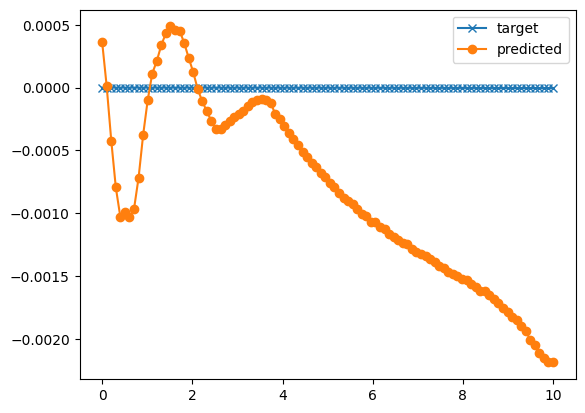

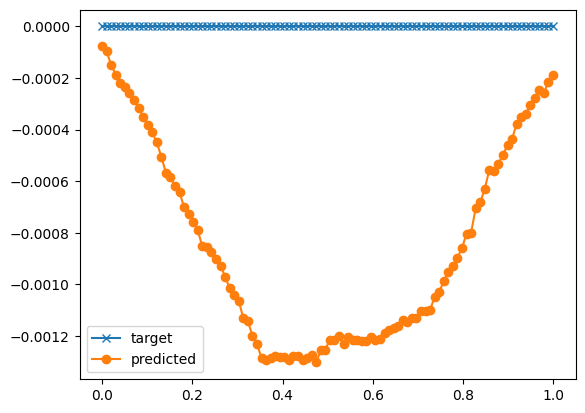

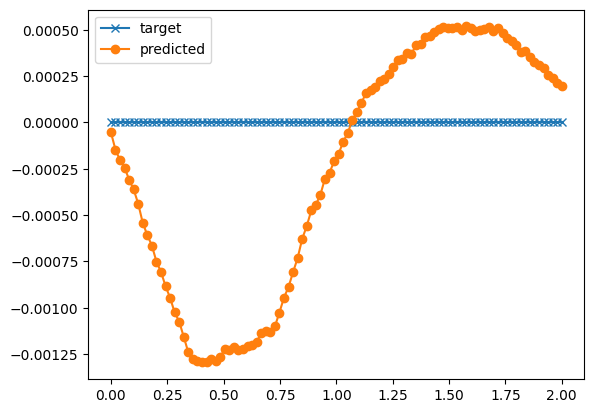

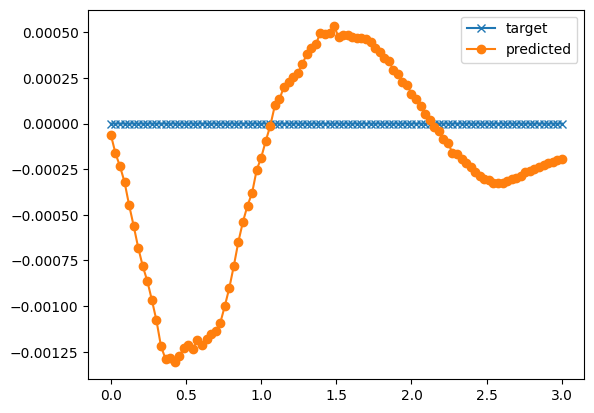

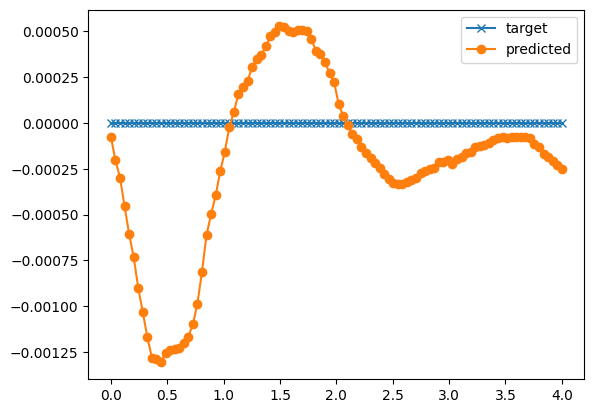

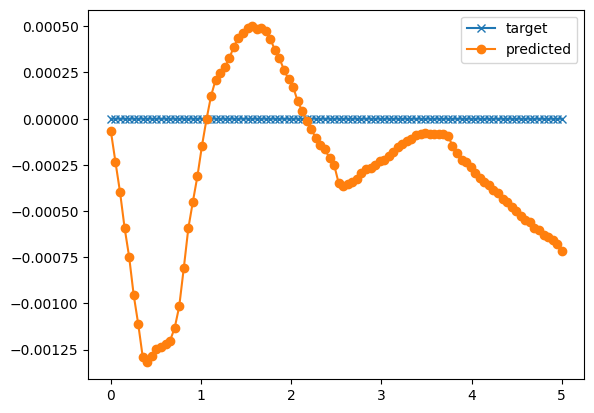

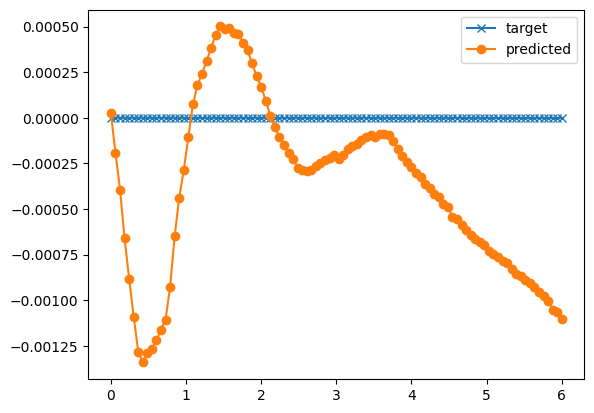

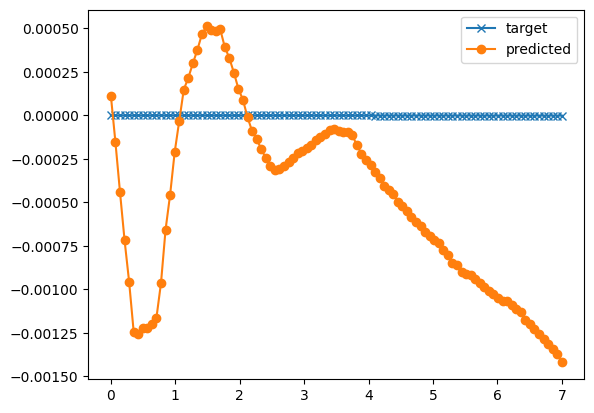

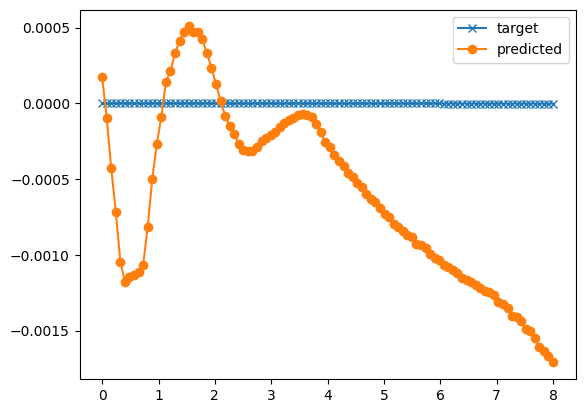

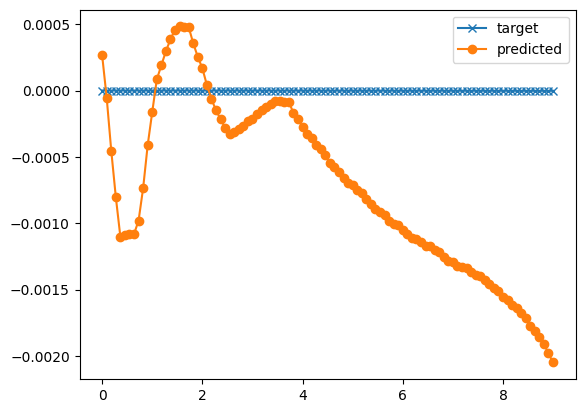

In [ ]:
# Test the model
def test_PDE(model, dataloader):
    loss = 0
    for batch_index, graph in enumerate(dataloader):
        model.eval()
        graph = graph.to(device)
        pred, target = model(graph)
        loss += F.mse_loss(pred, target).item()

    return loss / len(dataloader)

test_PDE(model, test_dataloader)

# Plot the results
plot_results(model, test_dataloader)